# PCA

Before performing Principal Component Analysis (PCA), we first check the skewness of each variable to identify highly skewed distributions, which can distort the results. Variables with skewness greater than |1| are transformed using the Yeo–Johnson method to reduce asymmetry, making the data more normally distributed. After this transformation, all variables are standardized so that they have zero mean and unit variance, ensuring that differences in scale do not dominate the PCA. Finally, PCA is applied to the processed data to identify the principal components and analyze the variance explained by each.

Skewness de cada variable:
 ASM (Energy)                  19.439727
Contrast                       3.439545
Correlation                   -2.184519
Variance                      -0.749337
IDM (Homogeneity)              0.884229
Sum Average                    1.703800
Sum Variance                  -1.069692
Sum Entropy                   -2.755155
Entropy                        0.220187
Difference Variance            0.711897
Difference Entropy             0.447119
IMC1 (Info Measure Corr 1)    -0.243566
IMC2 (Info Measure Corr 2)    -2.226634
dtype: float64
Variables a transformar (|skewness| > 1.0): ['ASM (Energy)', 'Contrast', 'Correlation', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'IMC2 (Info Measure Corr 2)']


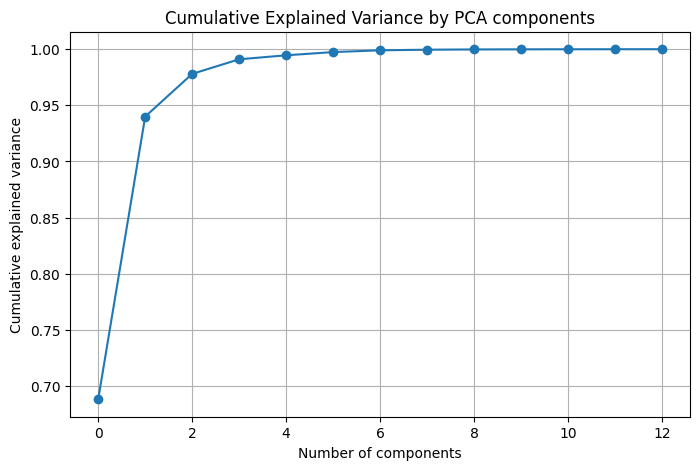

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import skew

# === LOAD YOUR DATA ===
file_path = r"C:\Users\ritaj\Documents\R\Rabanitos\datasets\dataset_completo.xlsx"
df = pd.read_excel(file_path)

features = [
    'ASM (Energy)', 'Contrast', 'Correlation', 'Variance',
    'IDM (Homogeneity)', 'Sum Average', 'Sum Variance', 'Sum Entropy',
    'Entropy', 'Difference Variance', 'Difference Entropy',
    'IMC1 (Info Measure Corr 1)', 'IMC2 (Info Measure Corr 2)'
]
X = df[features].copy()

# === DETECCIÓN DE SKEWNESS ===
skew_vals = X.apply(lambda col: skew(col.dropna()), axis=0)
print("Skewness de cada variable:\n", skew_vals)

# Umbral de asimetría para transformar
threshold = 1.0
vars_to_transform = skew_vals[abs(skew_vals) > threshold].index.tolist()
print(f"Variables a transformar (|skewness| > {threshold}): {vars_to_transform}")

# === TRANSFORMACIÓN YEO–JOHNSON SOLO A VARIABLES SESGADAS ===
if vars_to_transform:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    X[vars_to_transform] = pt.fit_transform(X[vars_to_transform])

# === ESTANDARIZACIÓN ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === PCA ===
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# === VARIANCE EXPLAINED PLOT ===
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance by PCA components')
plt.grid(True)
plt.show()

We selected the first three principal components from the PCA based on the elbow rule, as the explained variance shows a clear inflection point at this point, indicating that these components capture most of the important information in the data.

Indices de observaciones anómalas según Hotelling's T²:
[   4    5    6   26   49   53   69   72   84   89   93  101  109  123
  164  169  175  206  280  285  323  362  368  424  436  437  561  569
  654  671  673  683  699  701  713  721  722  741  742  751  753  760
  764  797  798  805  820  836  837  839  861  874  876  887  908  914
  915  918  929  930  941  955  961  972  974  981  985  994 1010 1019
 1024 1025 1034 1069 1070 1077 1115 1118 1132 1137 1146 1147 1148 1152
 1172 1173 1177 1197 1198 1212 1214 1216 1224 1237 1249 1250 1254 1256
 1274 1275 1278 1284 1308 1317 1333 1334 1339 1350 1356 1357]

Valores T² de las observaciones anómalas:
[  9.50562436  11.87327334  10.77945629  10.61051799  10.0862113
   8.30699589   9.96320657  18.38368441  13.02623231  10.69258644
   9.32411742   9.70444757   8.68334344  14.62773161  10.66057732
   8.46687445  20.10595581  11.55320948 170.74314512   8.85925963
  13.06091367  11.5265934   17.76543048   7.95026424  15.874198
  11.64155924  

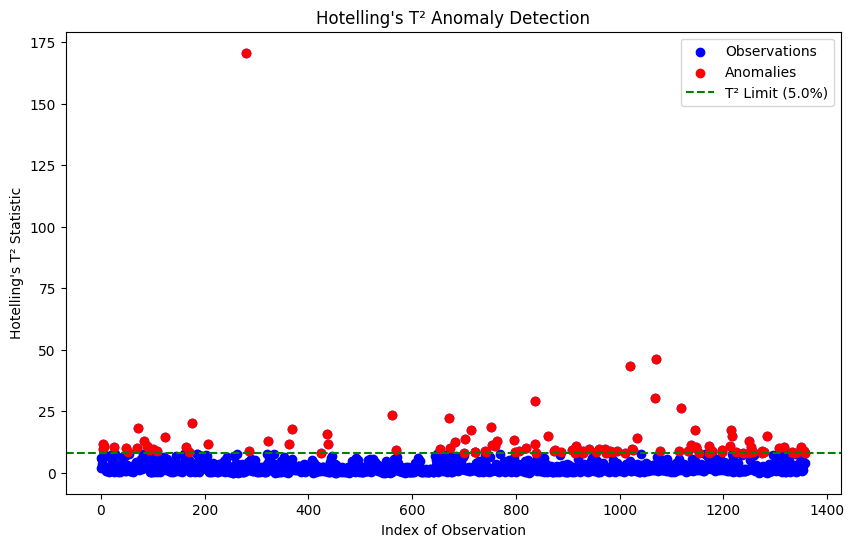

In [2]:
from scipy.stats import f
n_components = 3
pca = PCA(n_components=n_components)
T = pca.fit_transform(X_scaled)  # Scores (t)
P = pca.components_.T            # Loadings (p)

# === 3. Hotelling's T² ===
T2 = np.sum((T / np.std(T, axis=0))**2, axis=1)
n = X_scaled.shape[0]
alpha = 0.05
T2_limit = n_components * (n - 1) / (n - n_components) * f.ppf(1 - alpha, n_components, n - n_components)

# Identificar anomalías: T² mayor que el límite
anomalies = np.where(T2 > T2_limit)[0]

print("Indices de observaciones anómalas según Hotelling's T²:")
print(anomalies)

# Opcionalmente, imprimir los valores T² de esas observaciones
print("\nValores T² de las observaciones anómalas:")
print(T2[anomalies])

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Todos los puntos
plt.scatter(range(len(T2)), T2, label='Observations', color='blue')

# Puntos anómalos en rojo
plt.scatter(anomalies, T2[anomalies], color='red', label='Anomalies')

# Línea límite
plt.axhline(y=T2_limit, color='green', linestyle='--', label=f'T² Limit ({alpha*100:.1f}%)')

plt.xlabel('Index of Observation')
plt.ylabel("Hotelling's T² Statistic")
plt.title("Hotelling's T² Anomaly Detection")
plt.legend()
plt.show()


To analyze the origin of these anomalies, we will plot their scores by comparing the first principal component against each of the other components. This will help us observe if the anomalies follow any specific pattern or cluster in the reduced feature space.

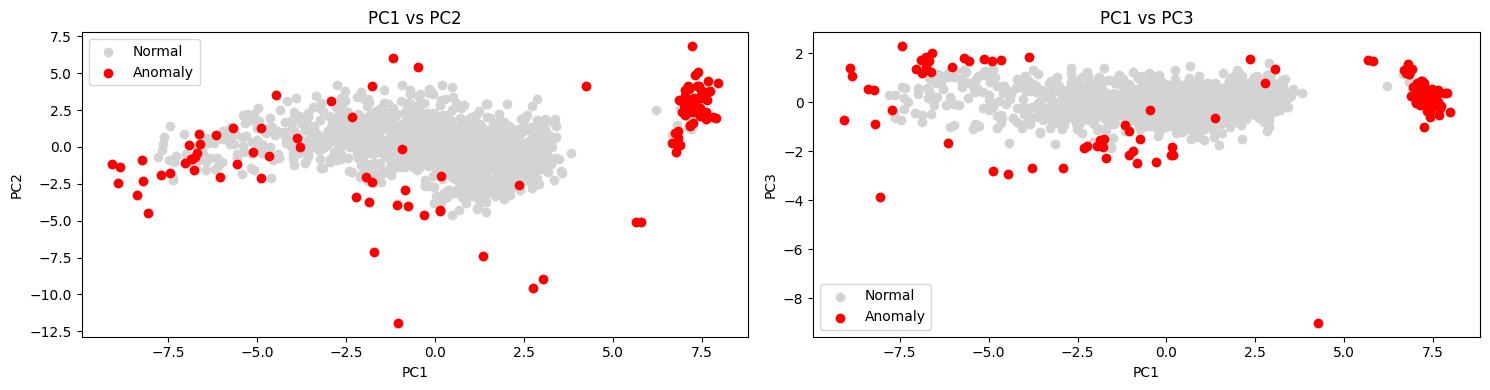

In [3]:
import matplotlib.pyplot as plt

# Número de componentes
n_components = 3

# Scores de PCA ya calculados: T (shape: n_samples x n_components)
# Índices de anomalías ya definidos: anomalies

plt.figure(figsize=(15, 4))

for i in range(1, n_components):
    plt.subplot(1, n_components-1, i)
    
    # Todos los puntos en gris claro
    plt.scatter(T[:, 0], T[:, i], color='lightgray', label='Normal')
    
    # Puntos anómalos en rojo
    plt.scatter(T[anomalies, 0], T[anomalies, i], color='red', label='Anomaly')
    
    plt.xlabel('PC1')
    plt.ylabel(f'PC{i+1}')
    plt.title(f'PC1 vs PC{i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


At first glance, it appears that most of the anomalies are mainly related to the first principal component of our model. 

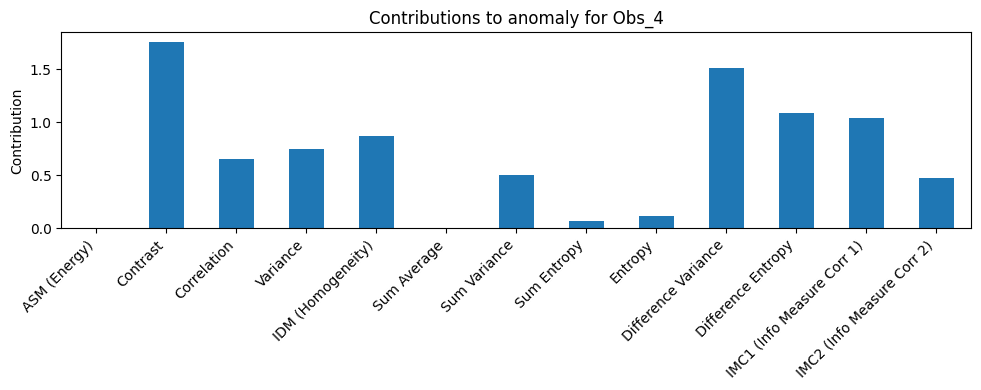

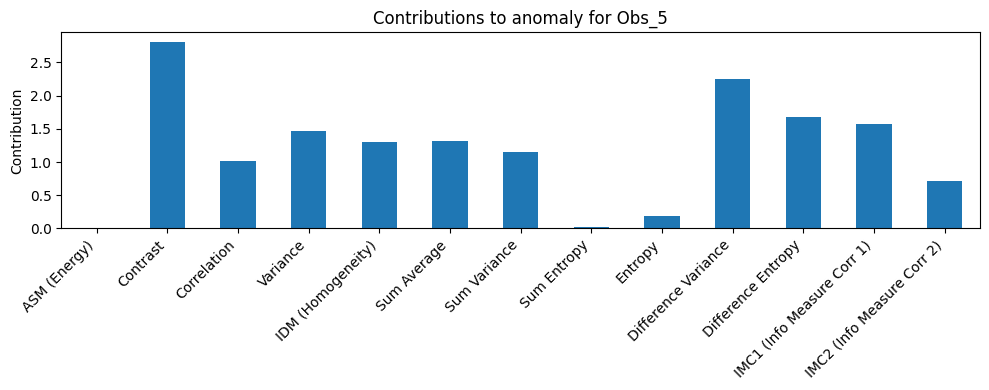

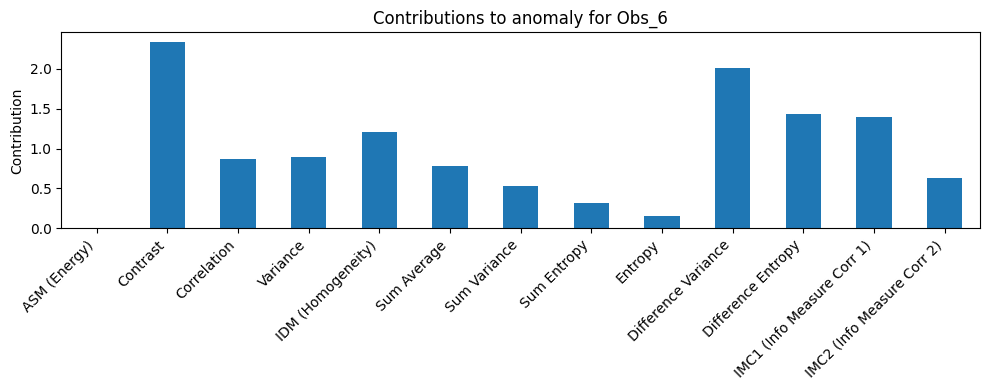

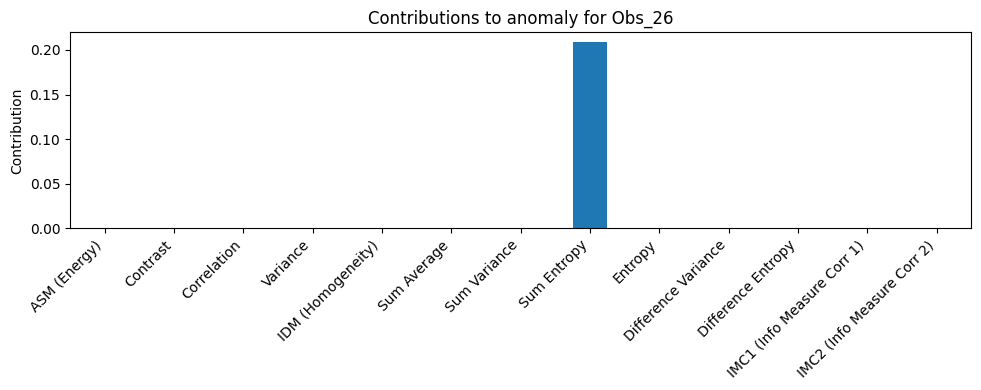

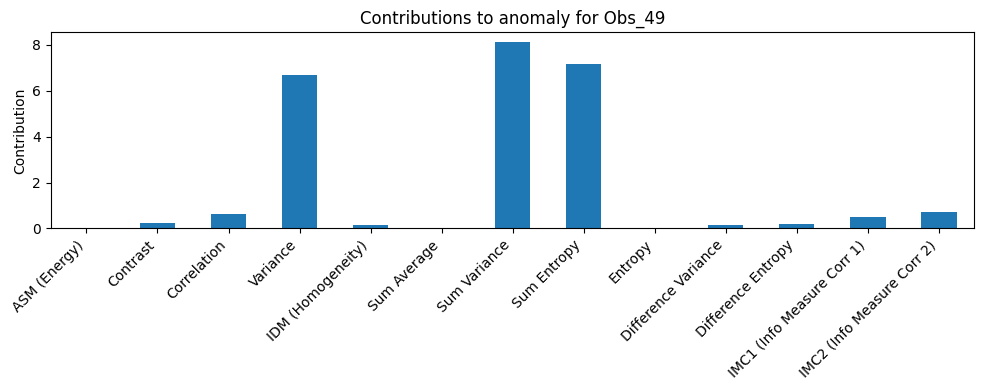

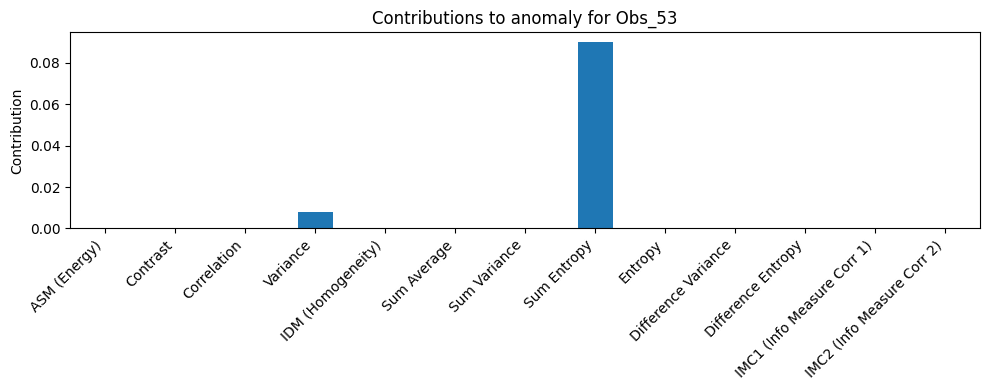

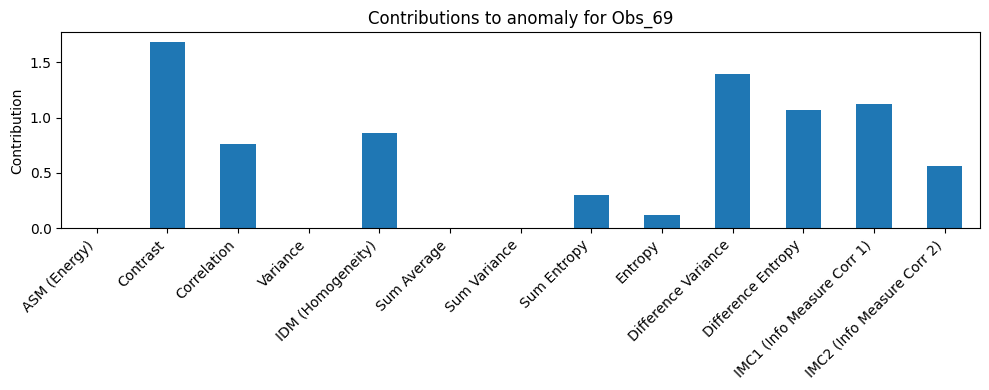

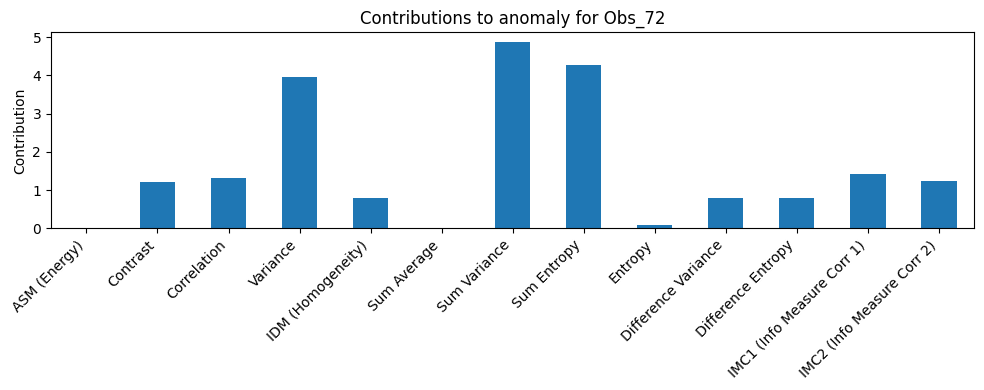

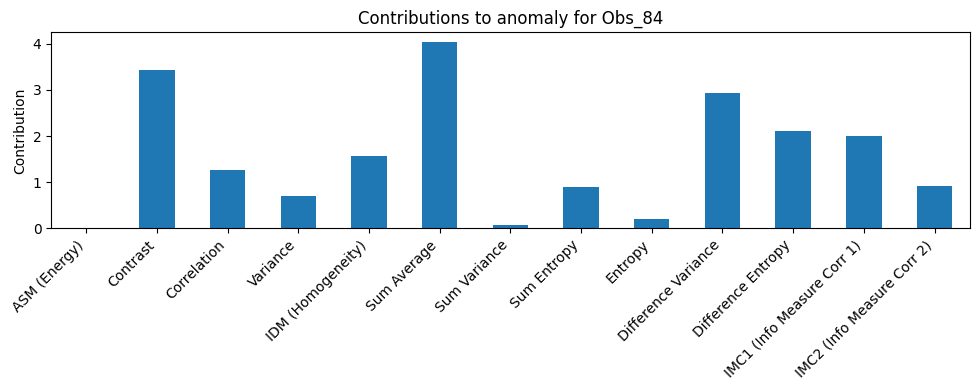

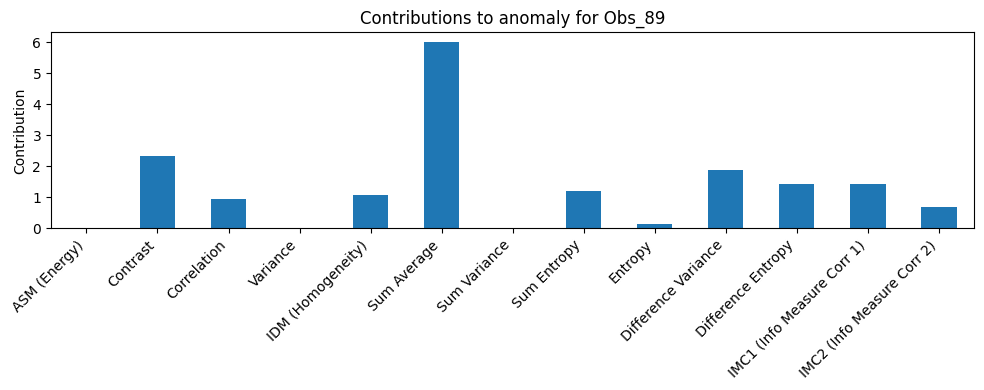

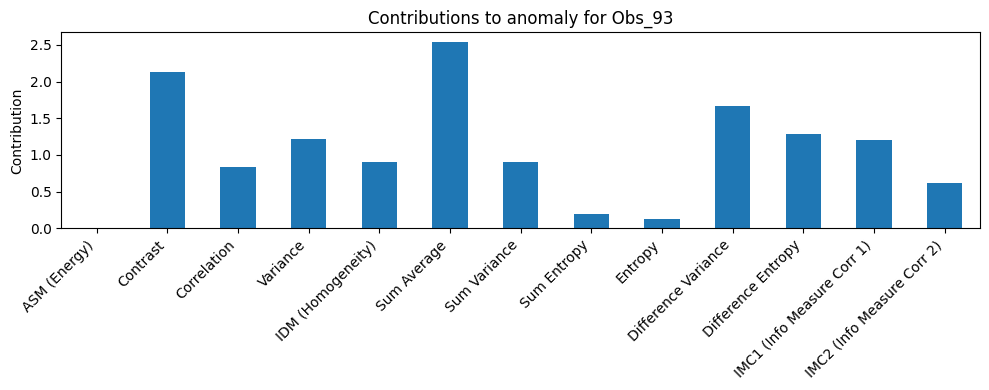

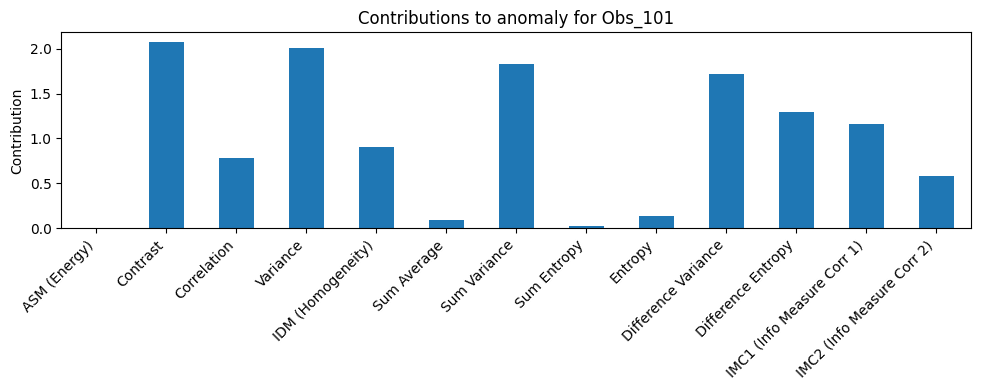

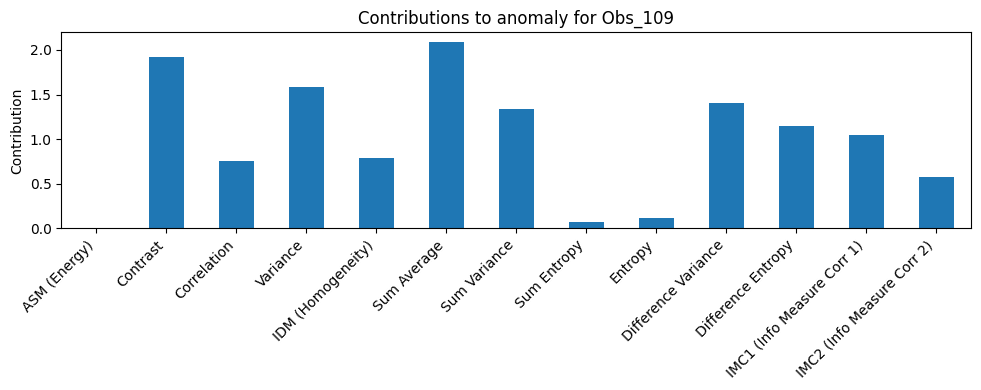

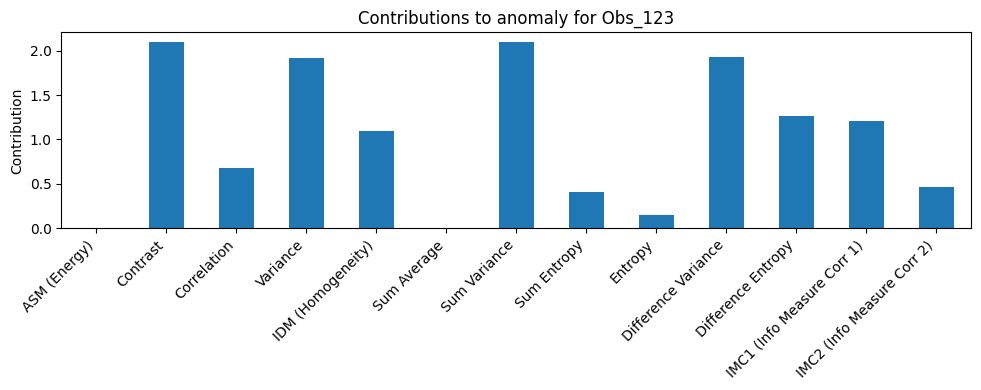

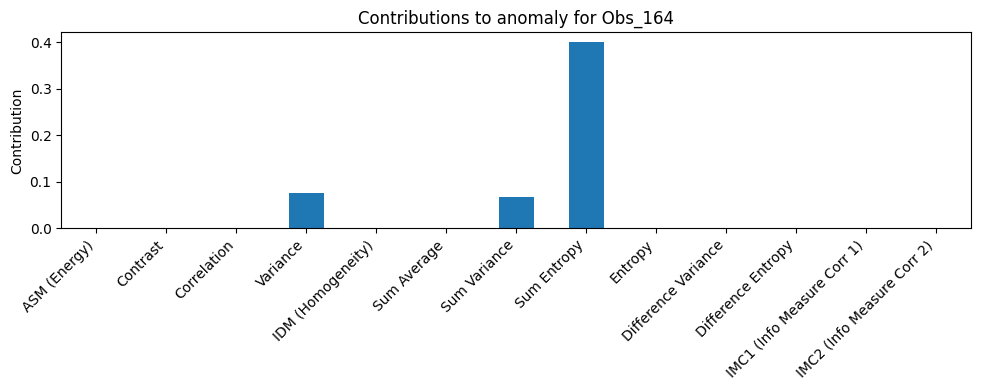

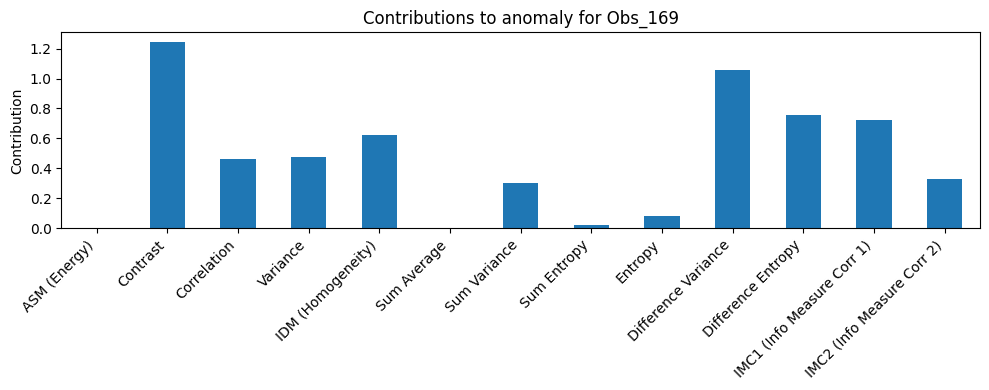

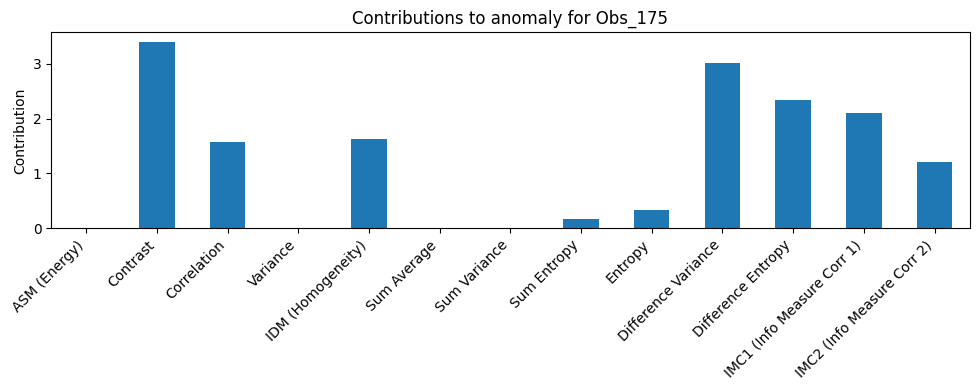

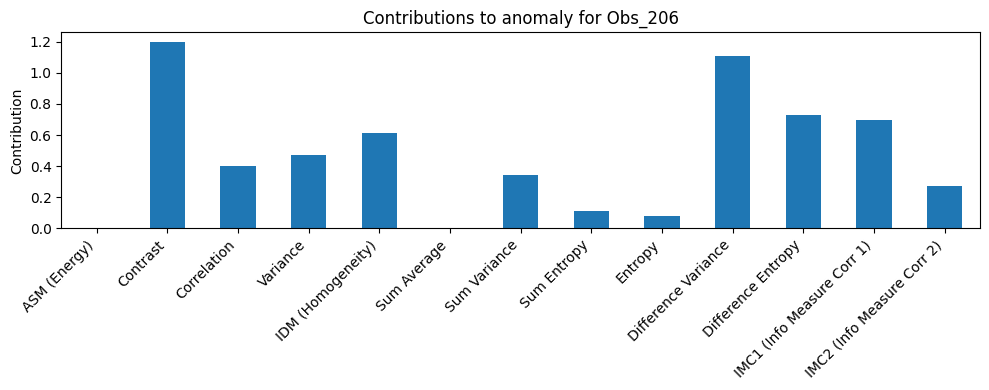

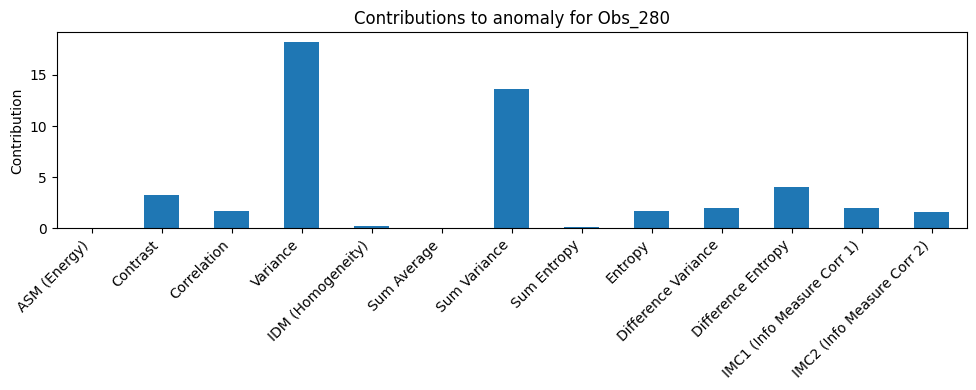

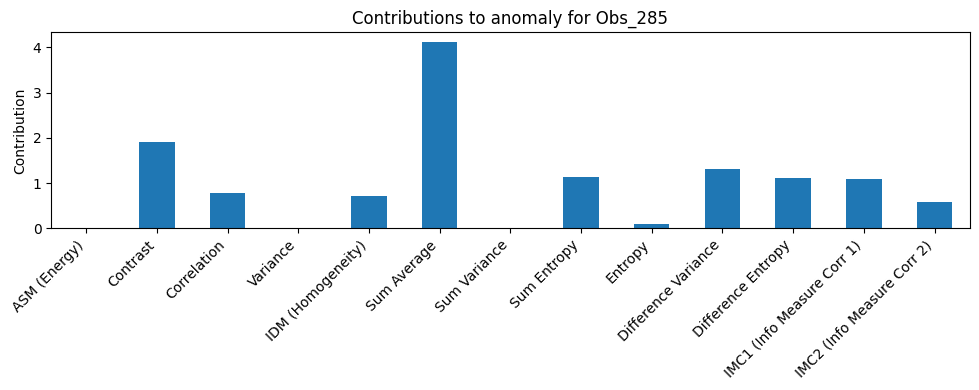

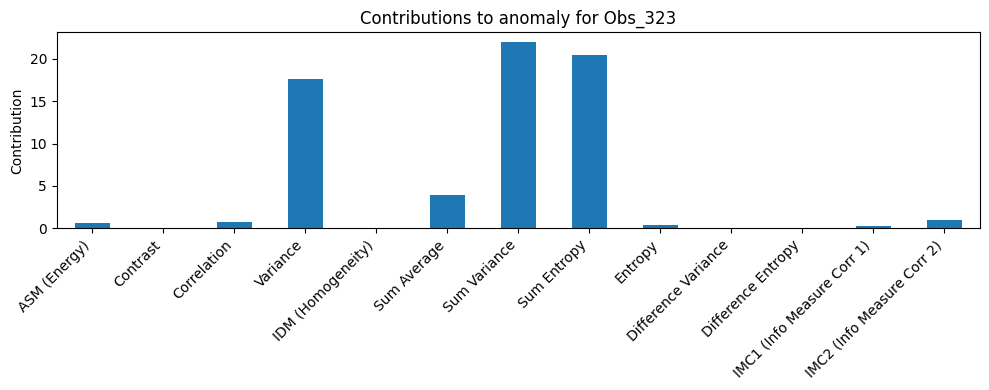

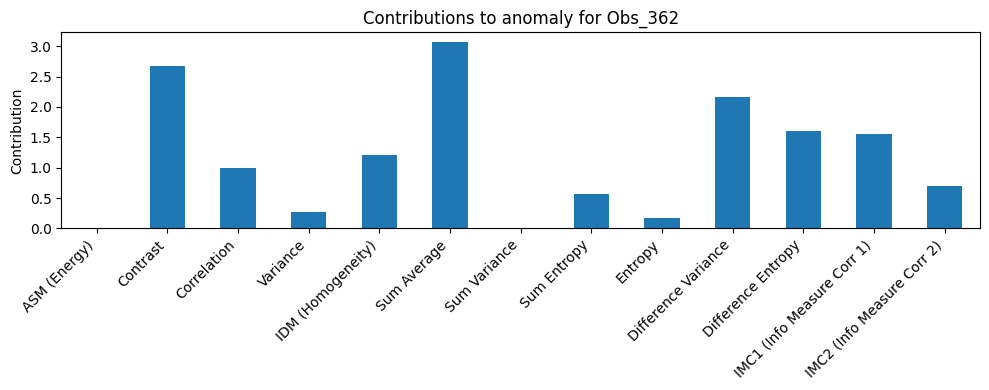

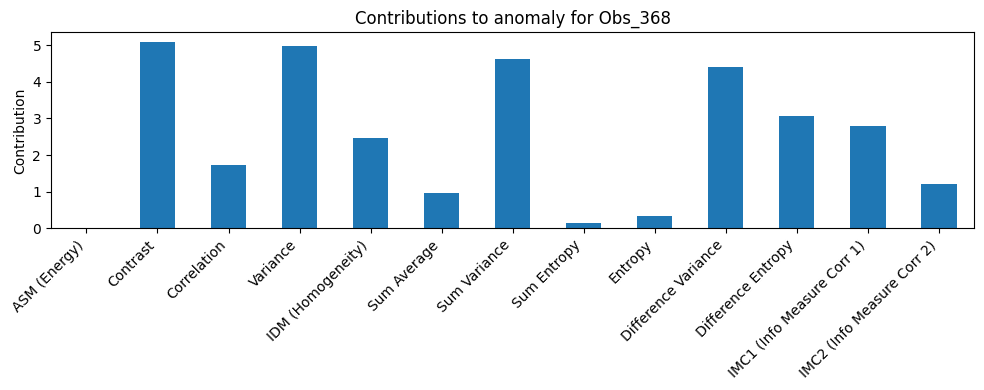

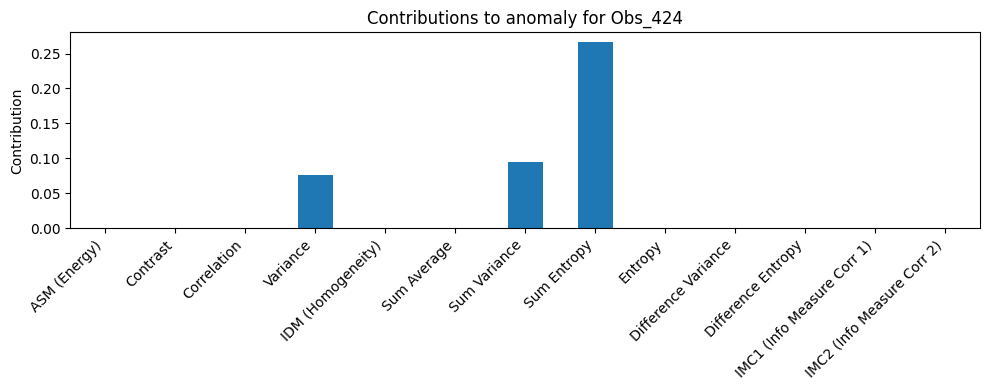

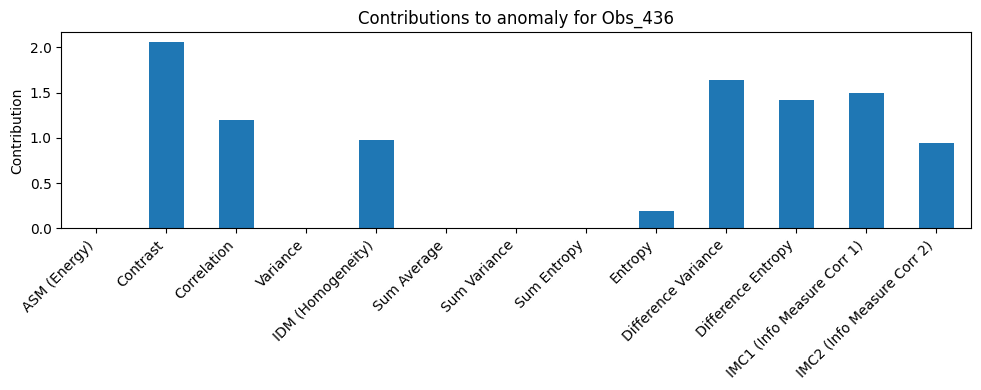

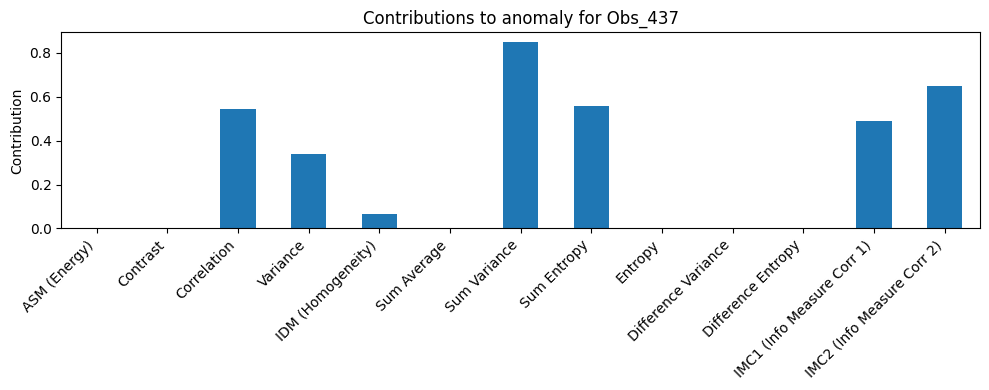

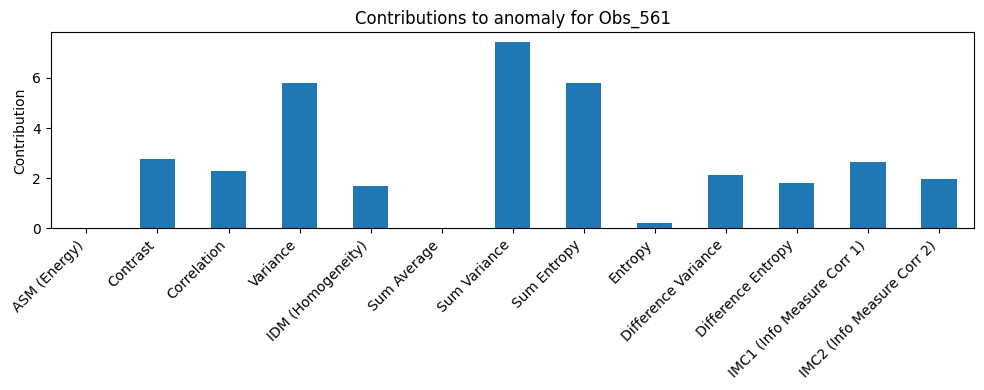

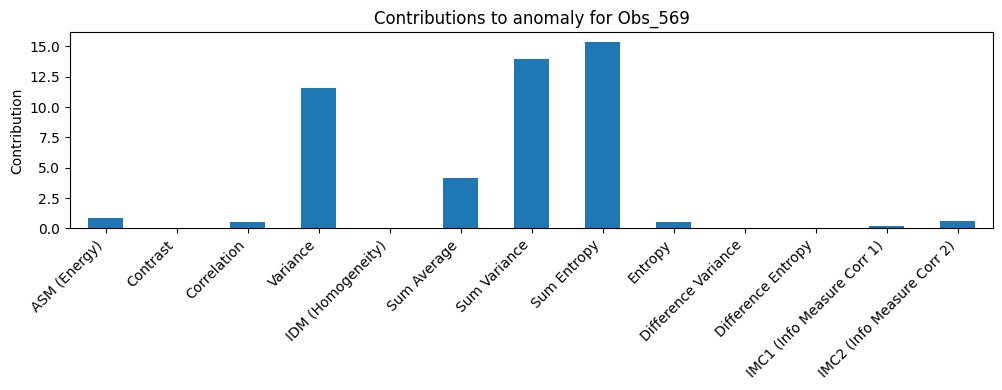

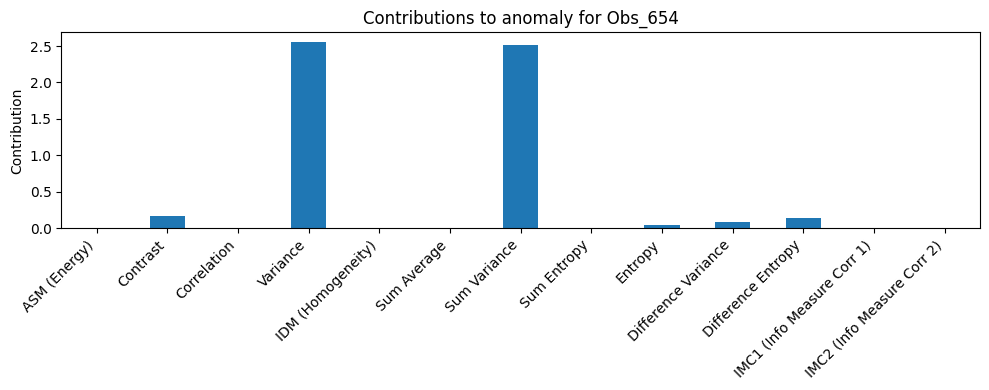

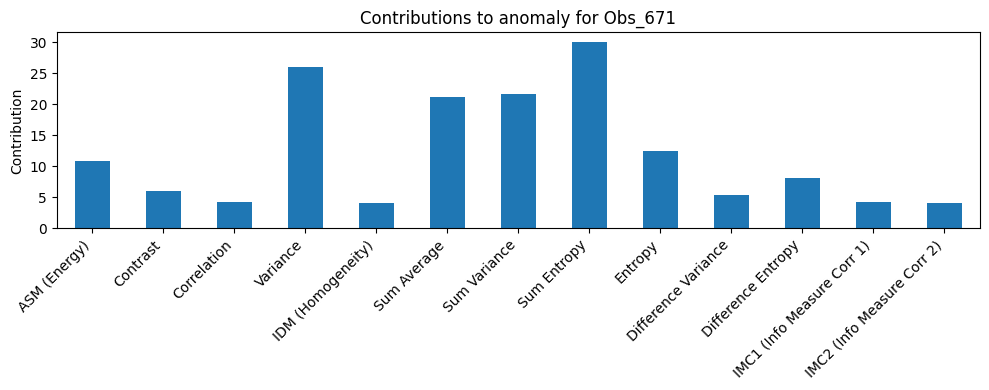

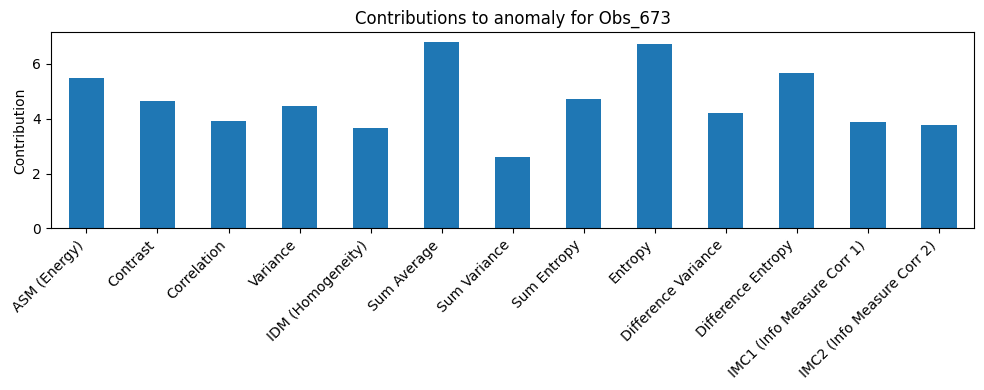

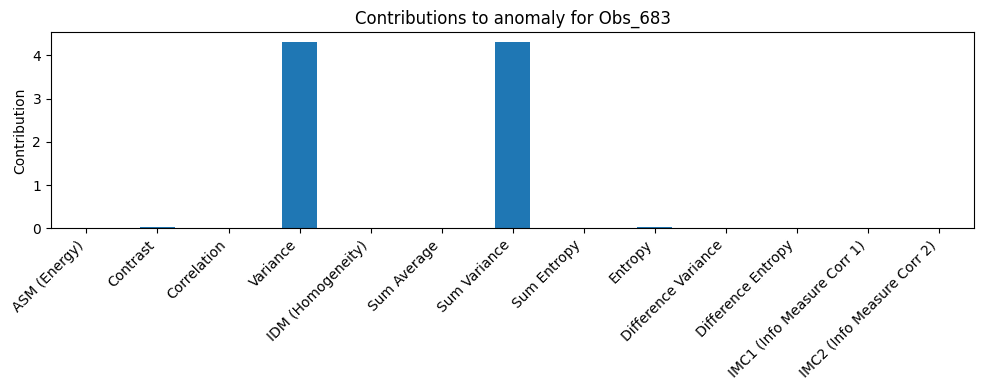

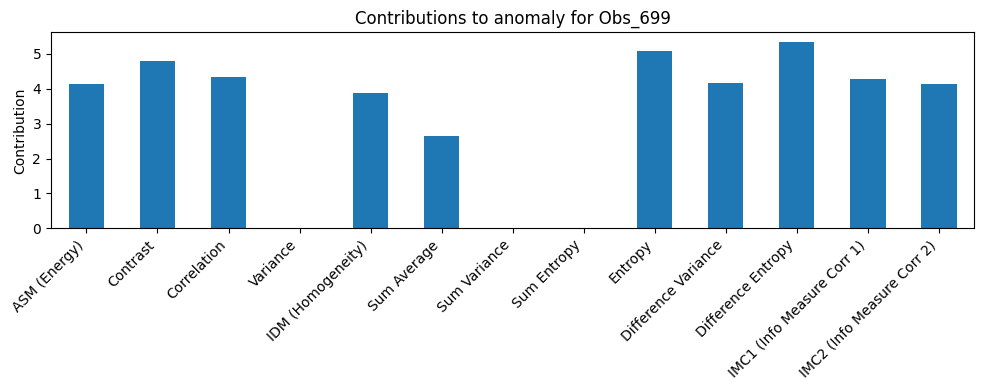

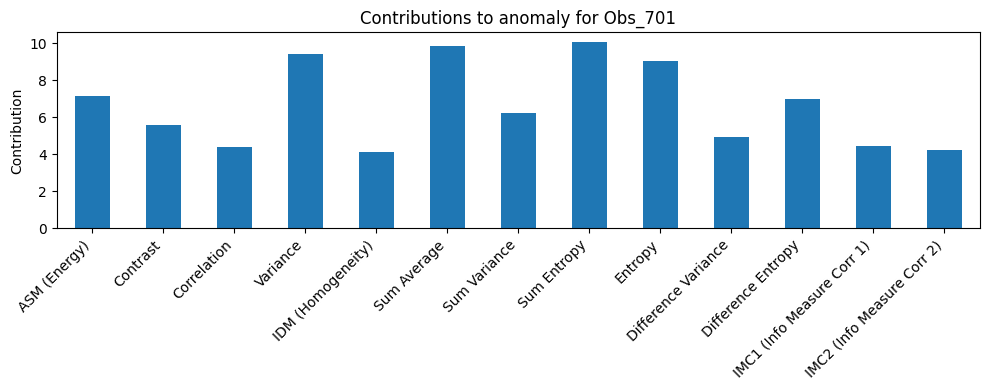

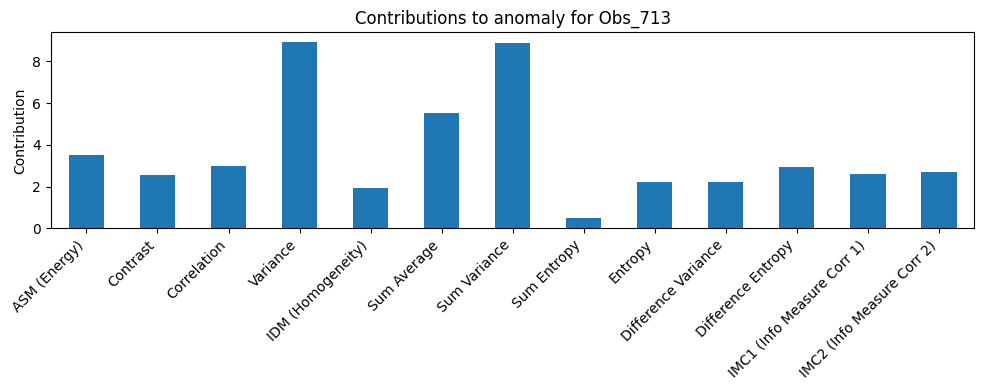

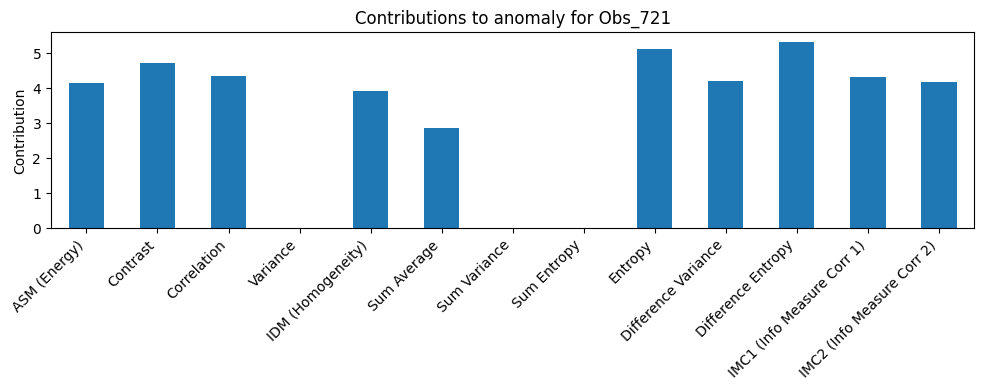

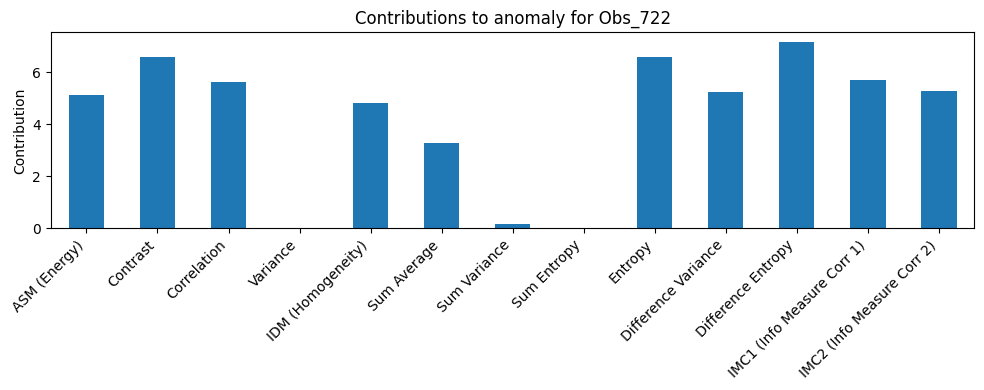

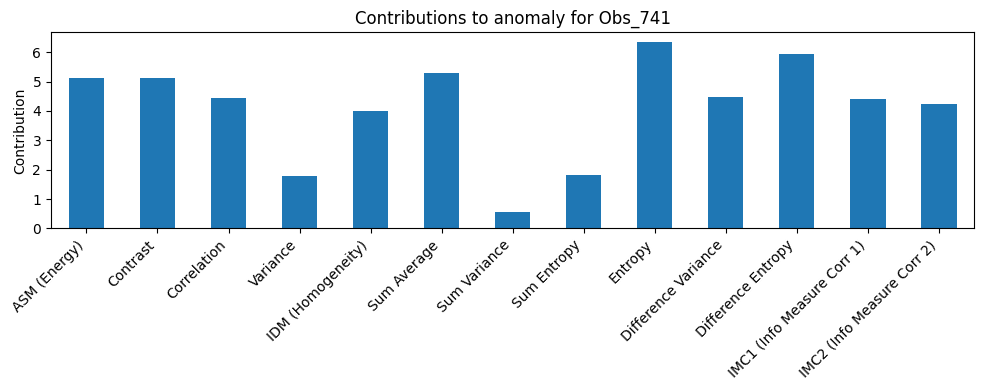

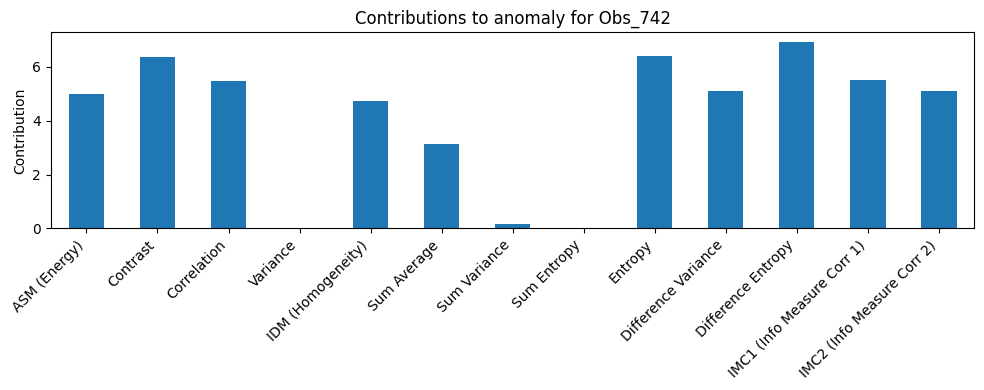

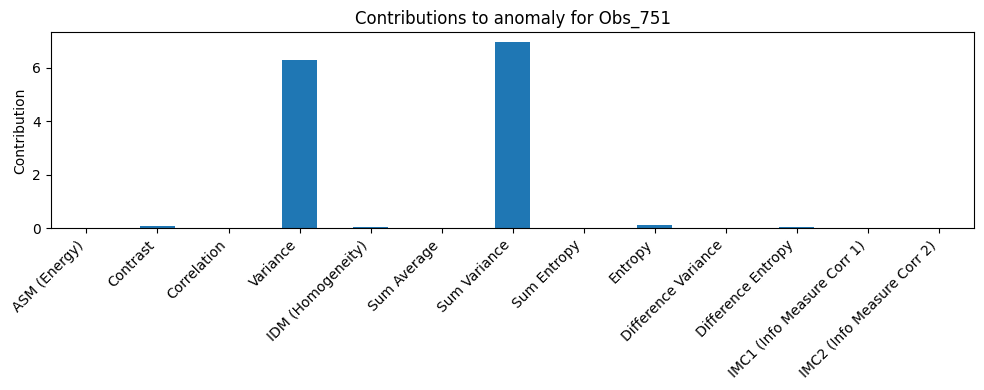

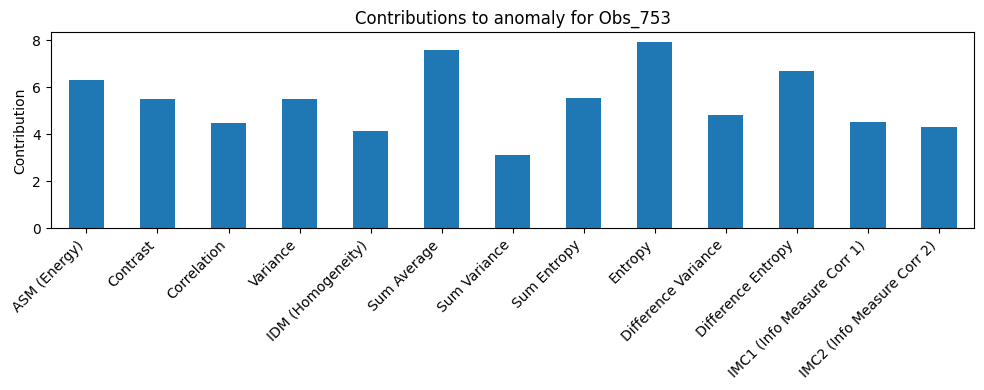

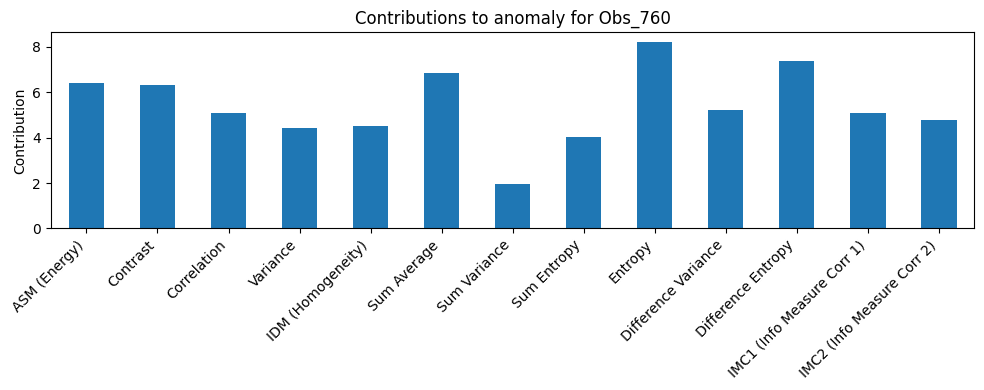

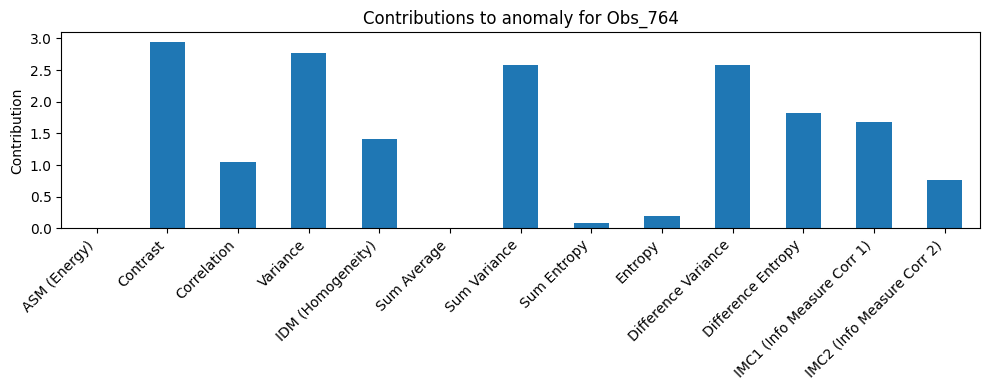

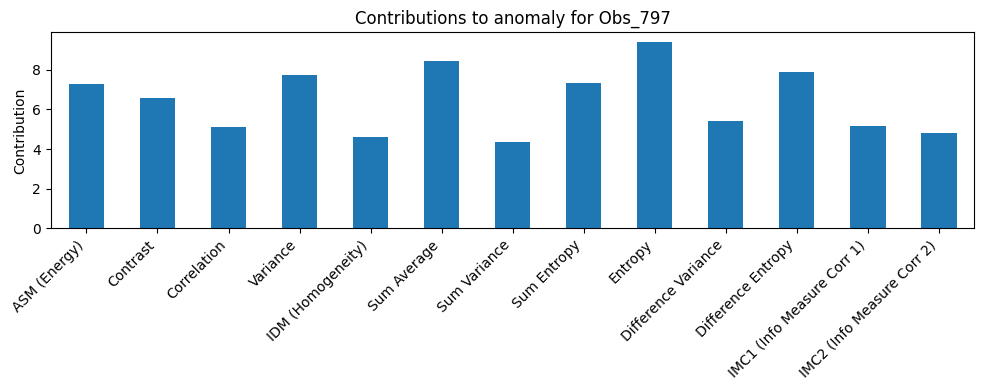

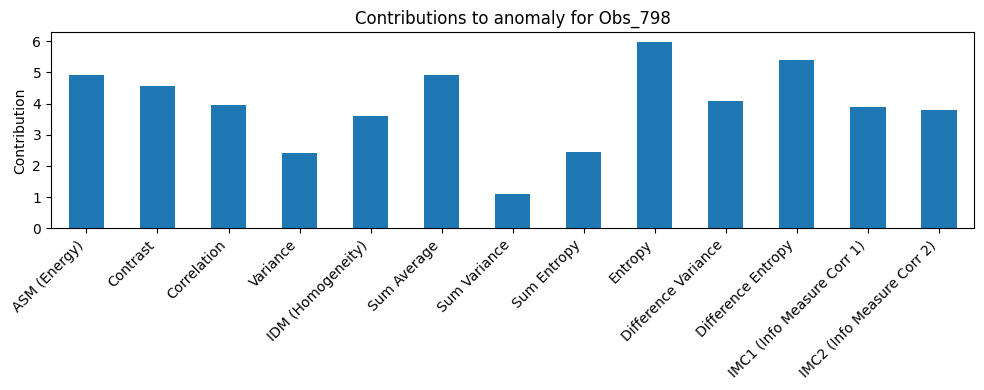

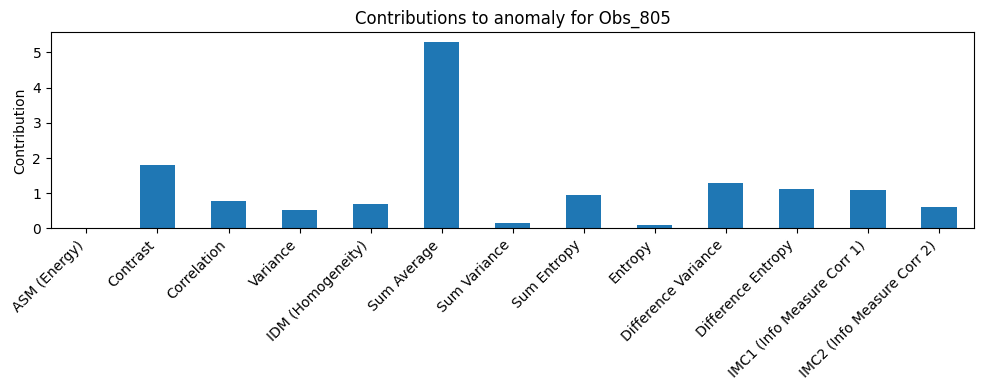

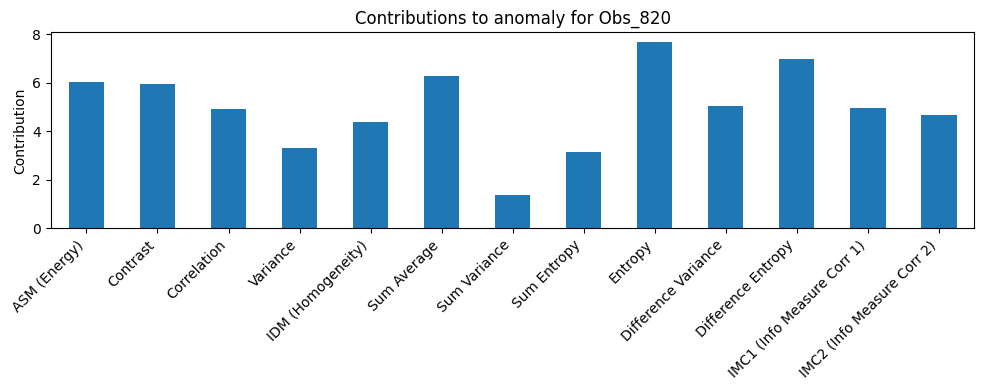

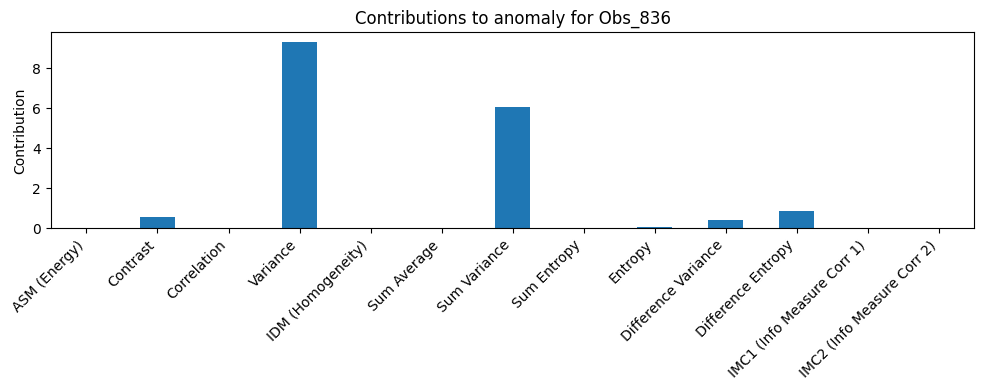

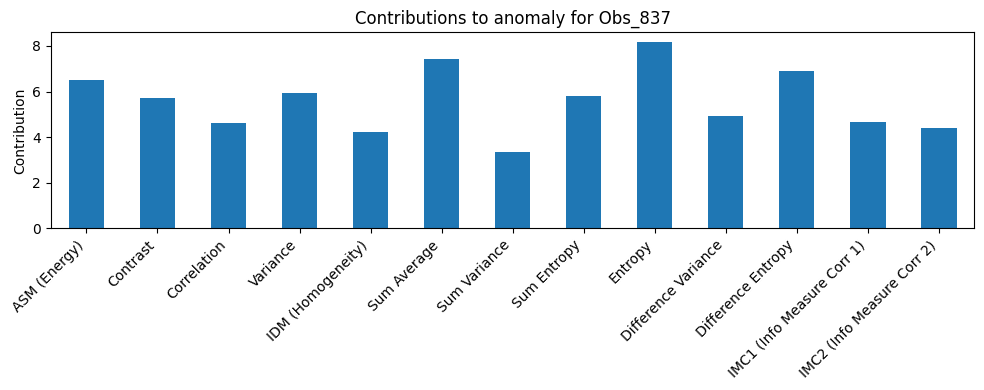

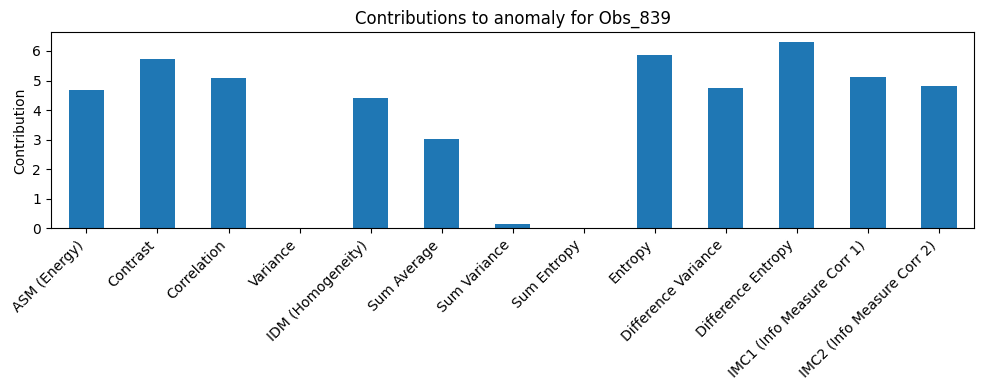

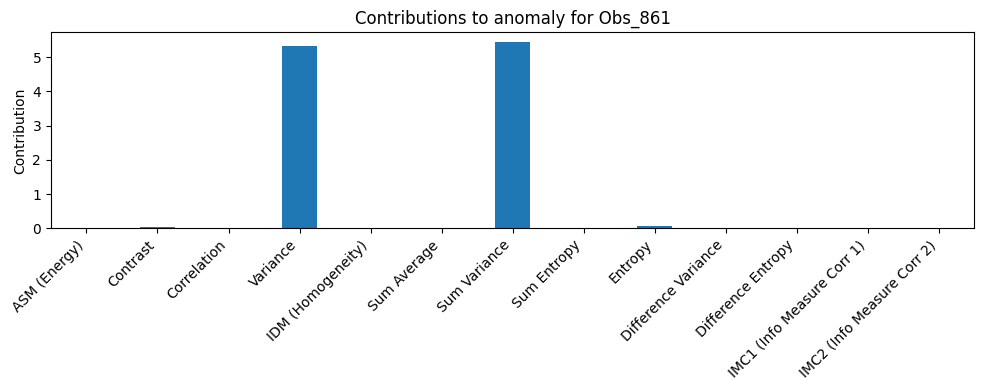

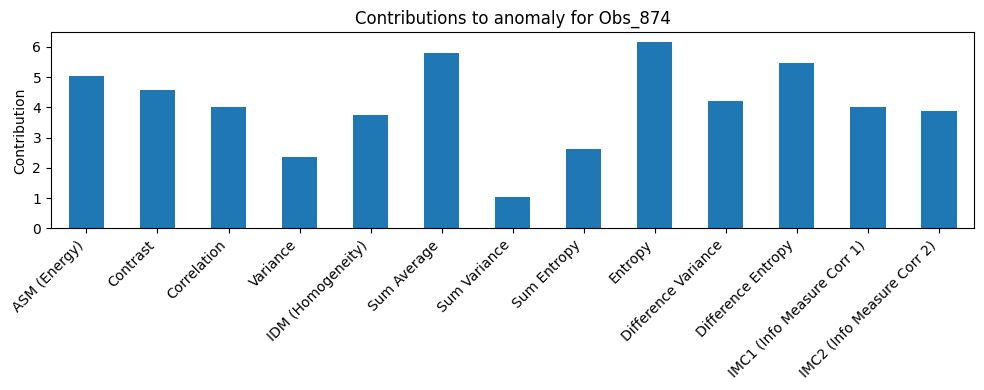

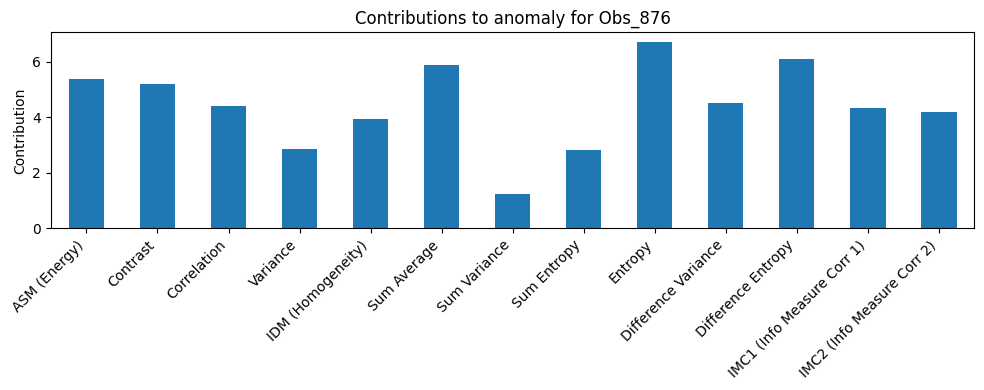

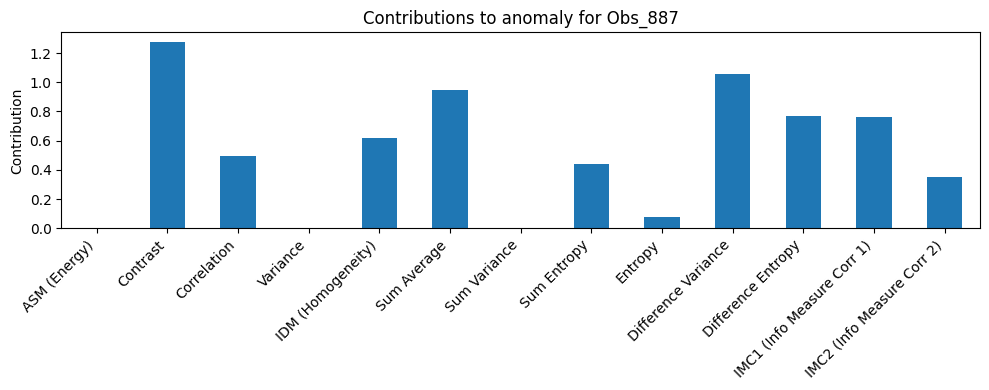

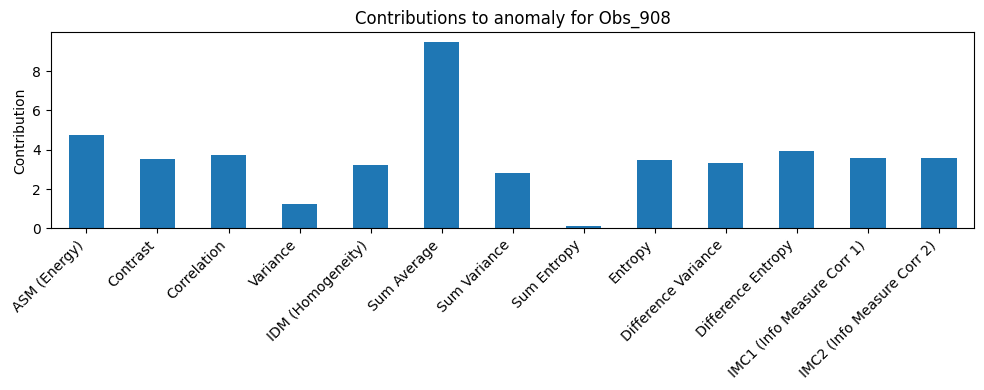

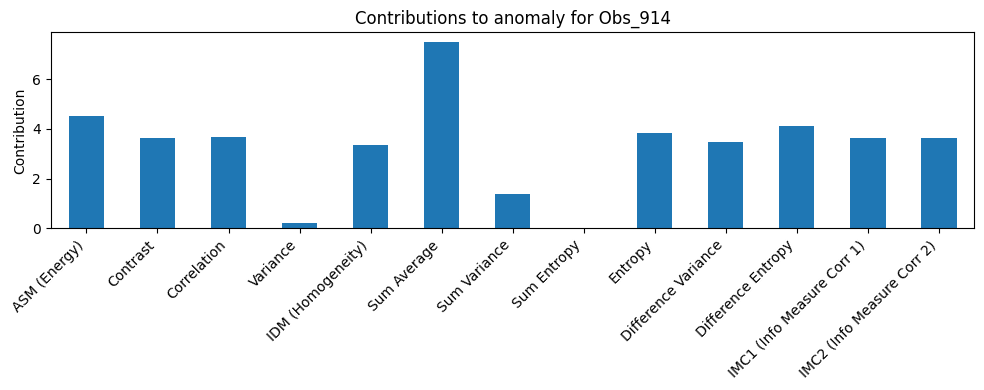

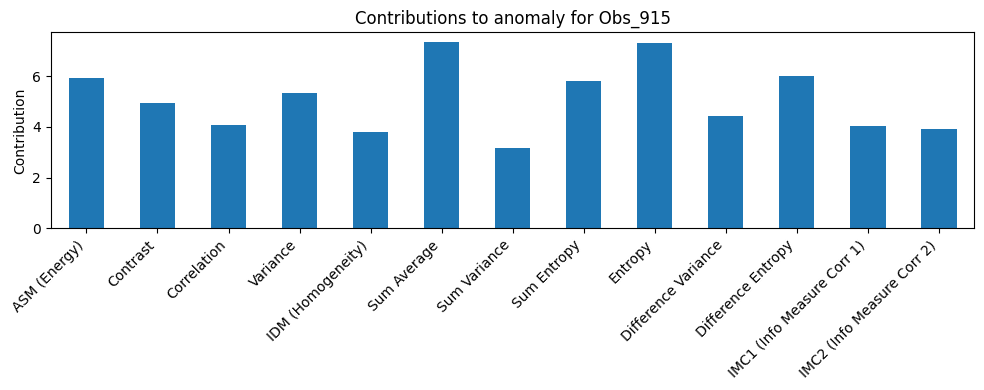

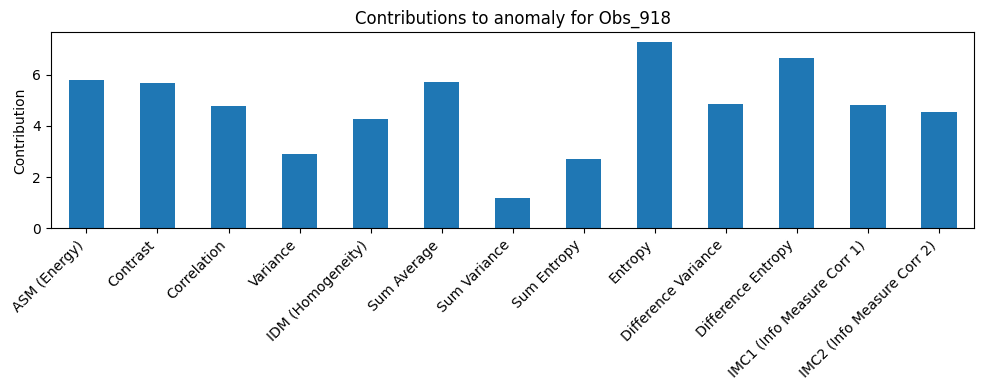

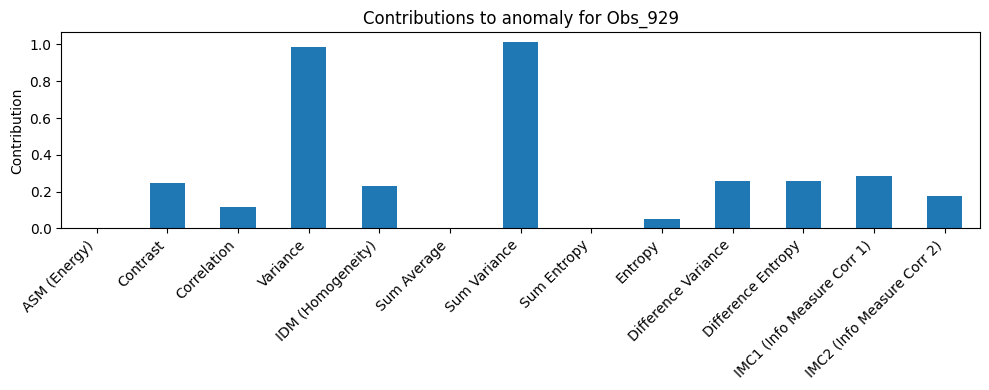

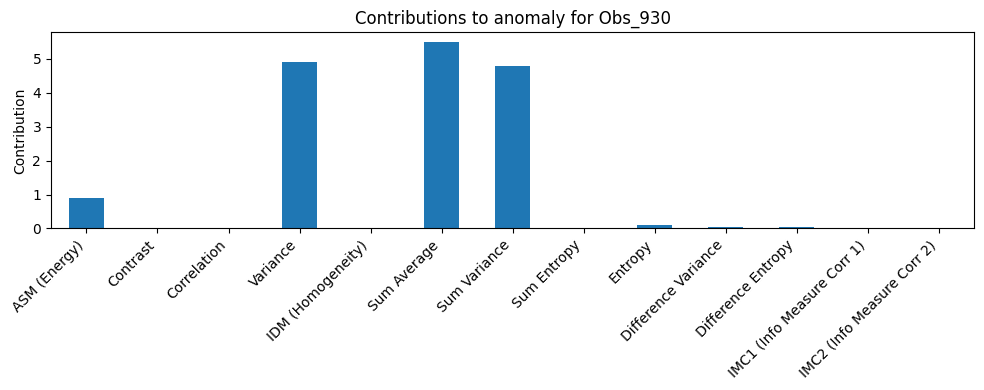

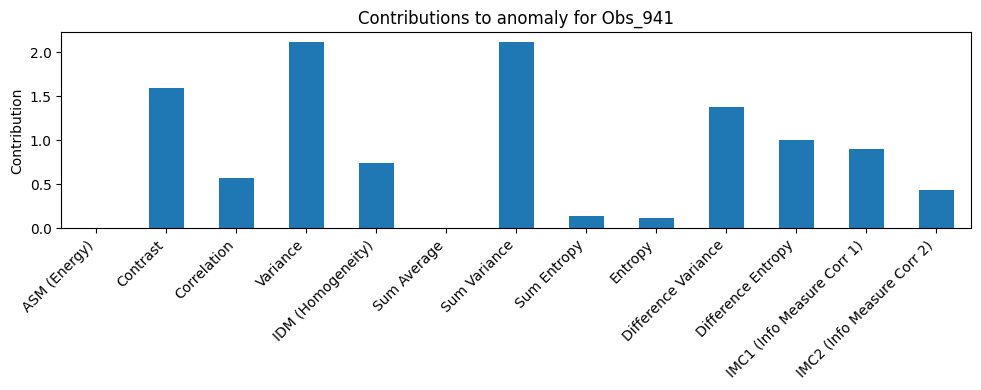

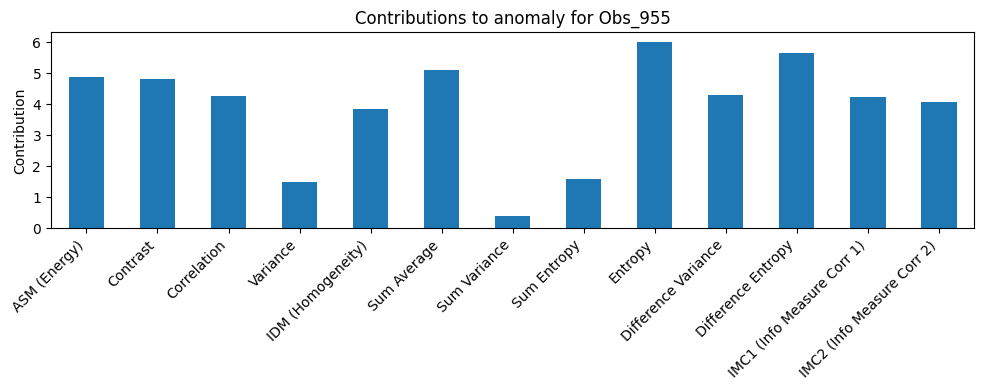

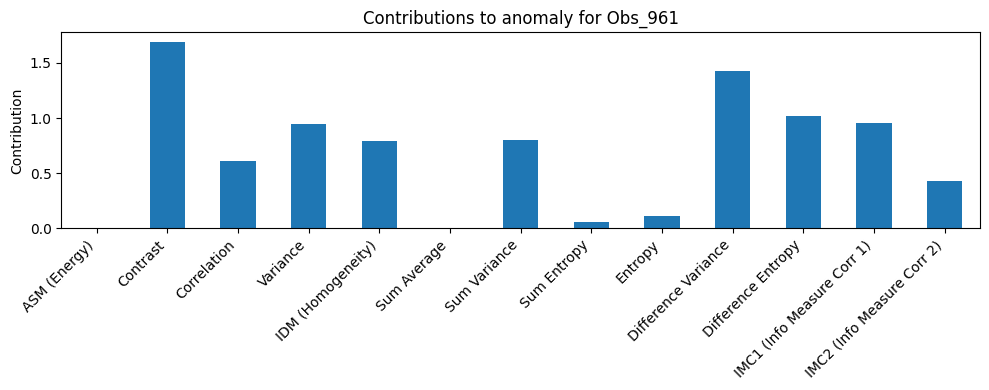

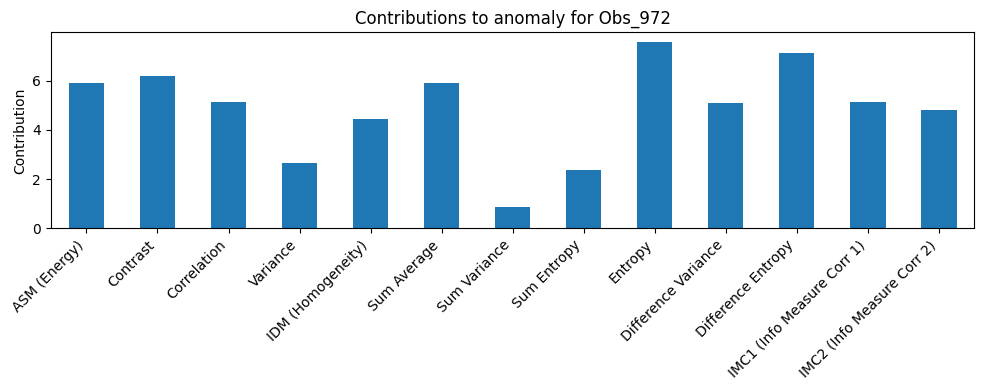

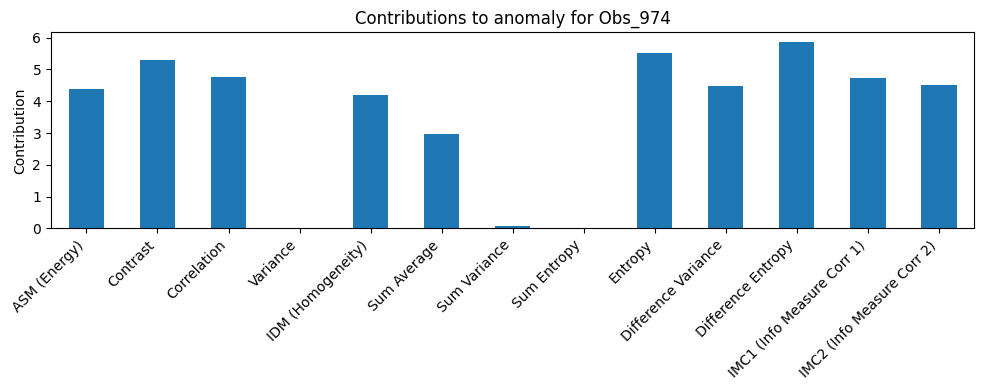

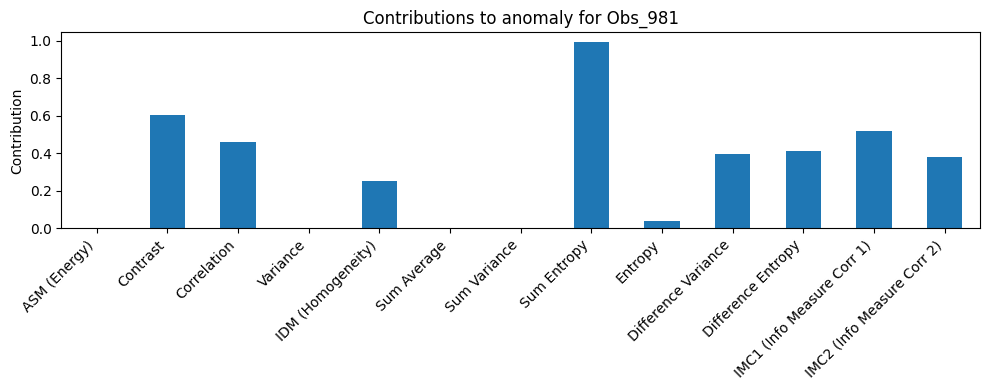

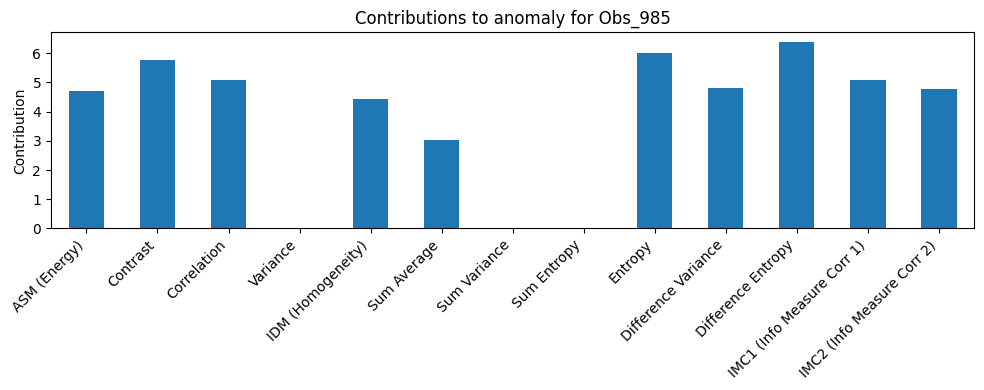

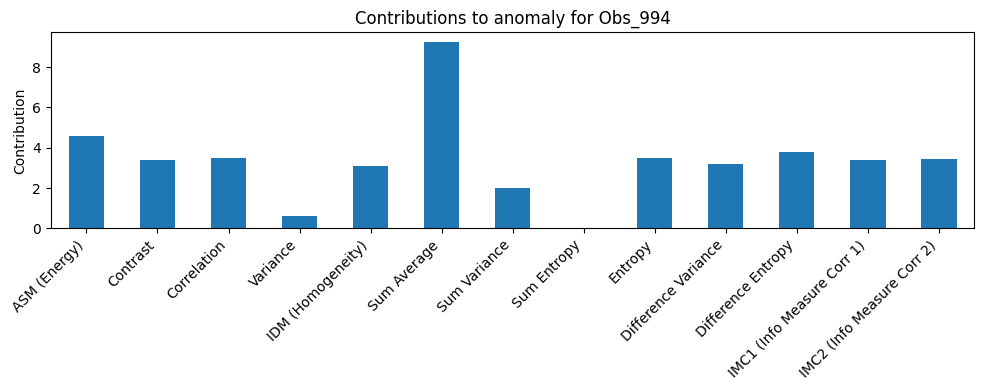

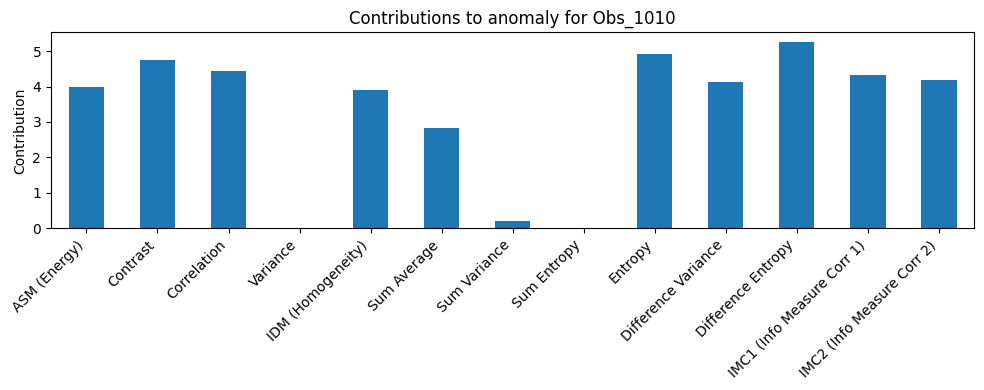

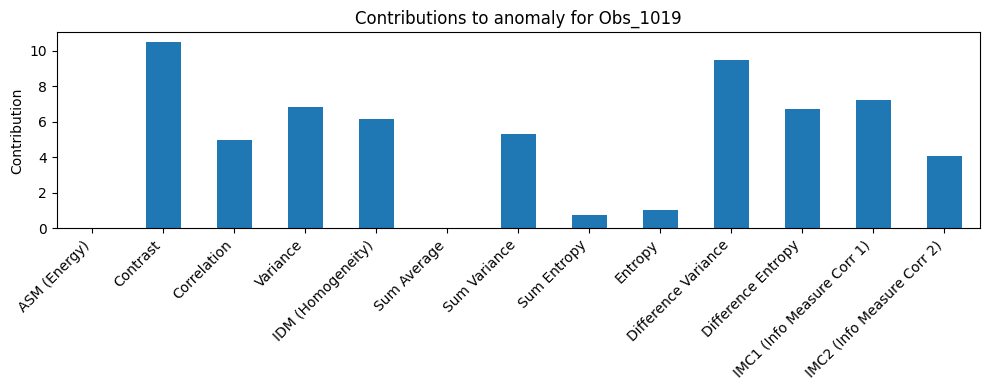

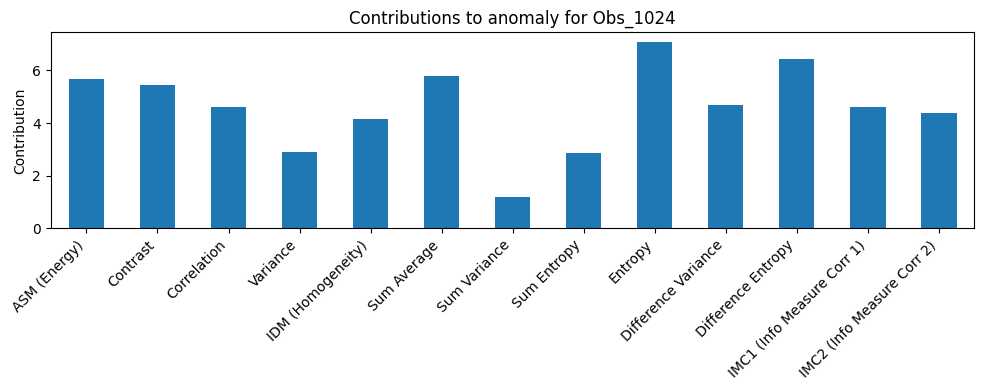

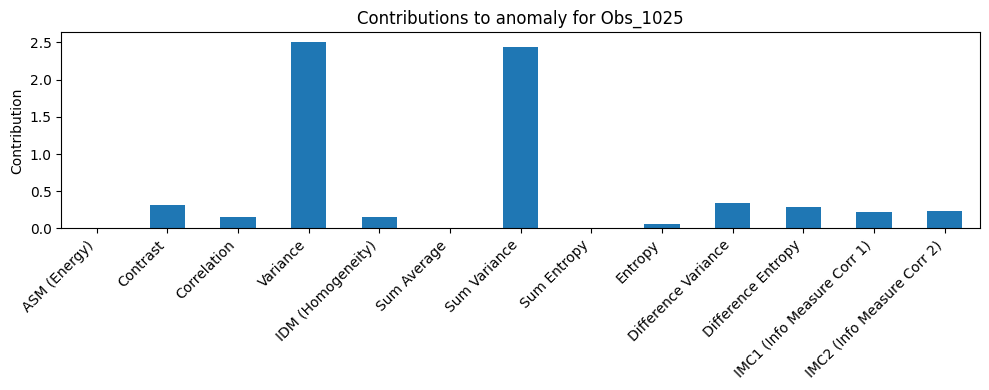

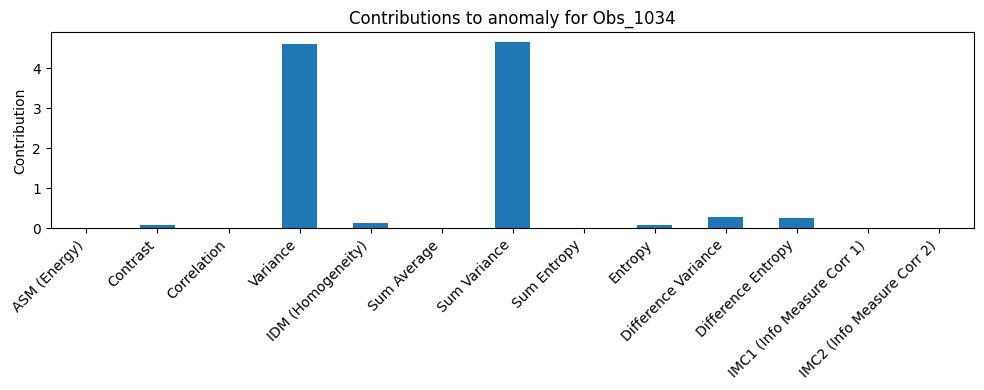

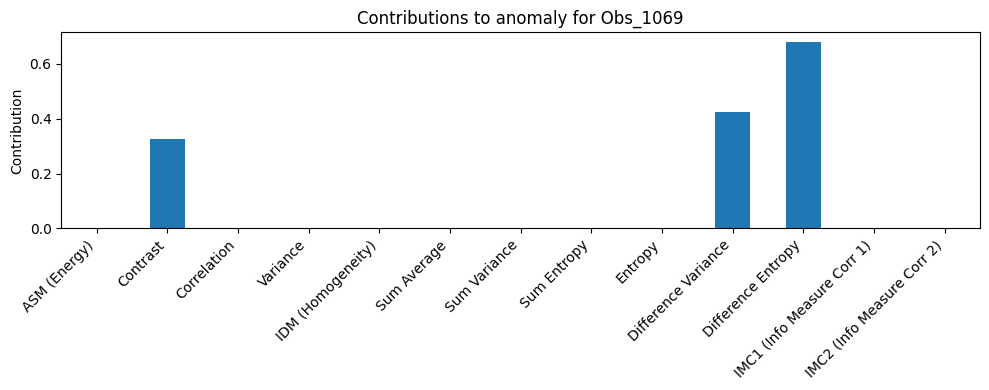

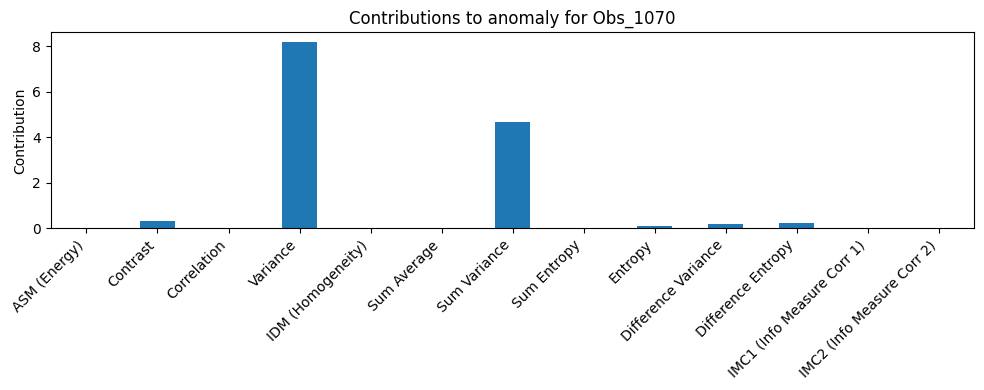

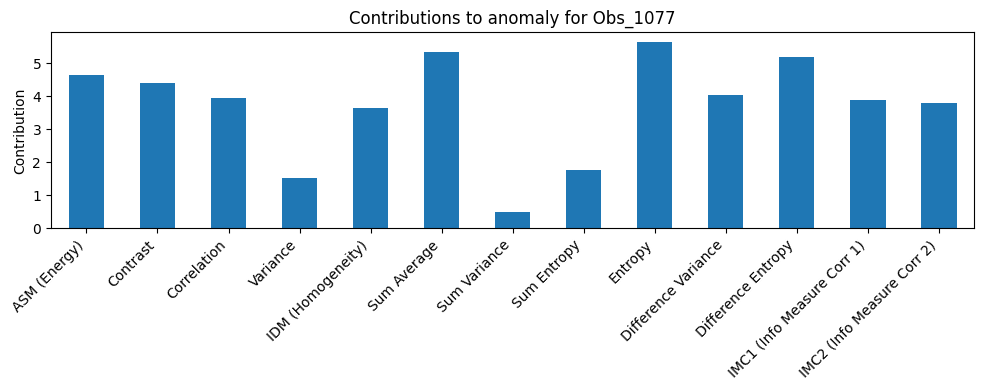

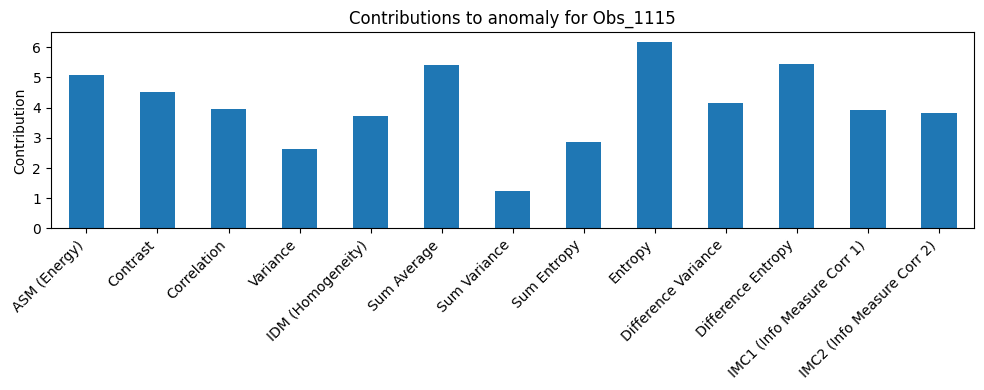

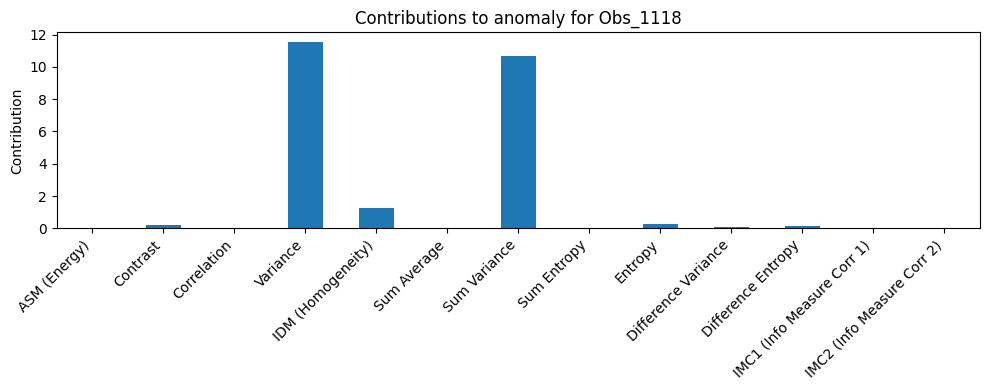

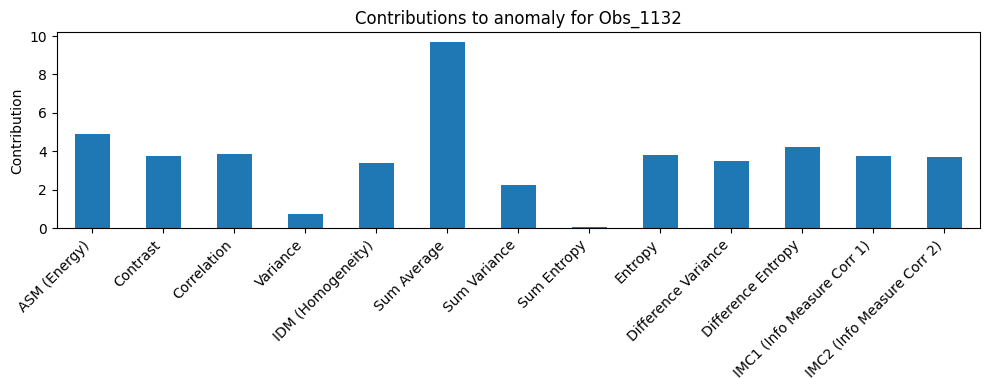

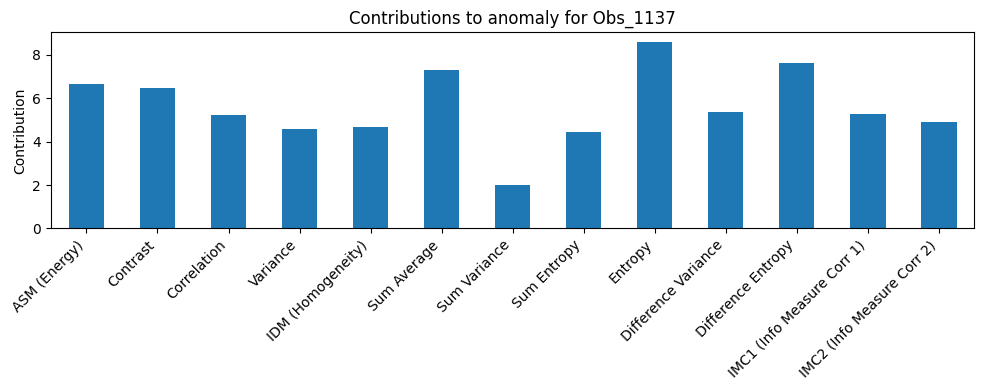

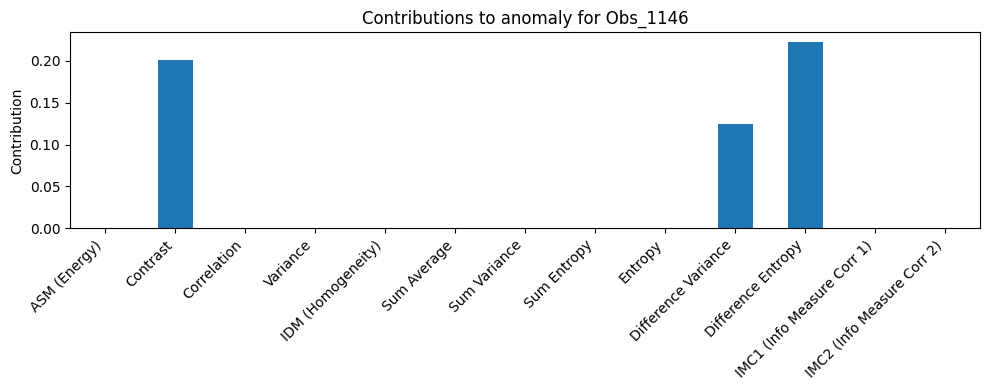

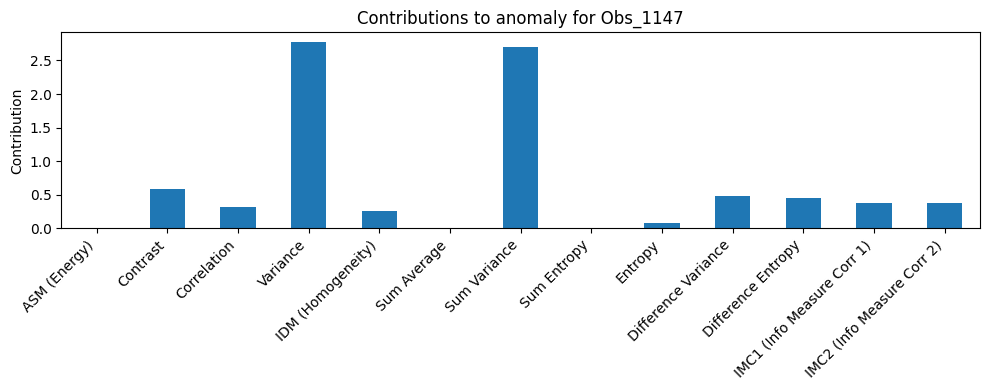

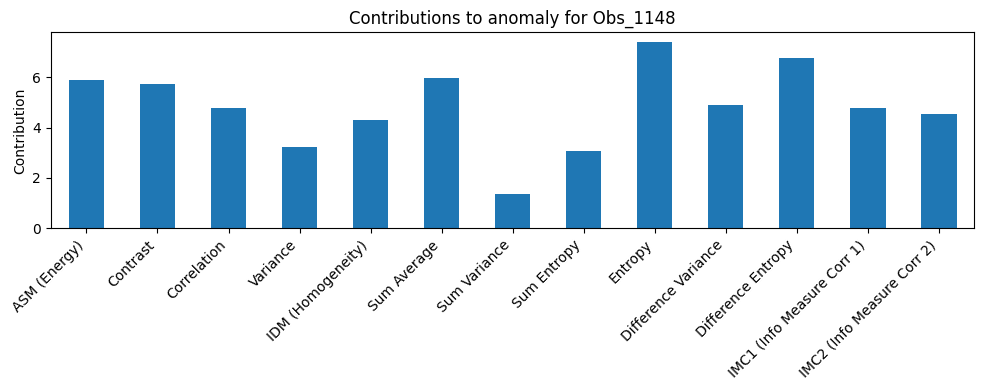

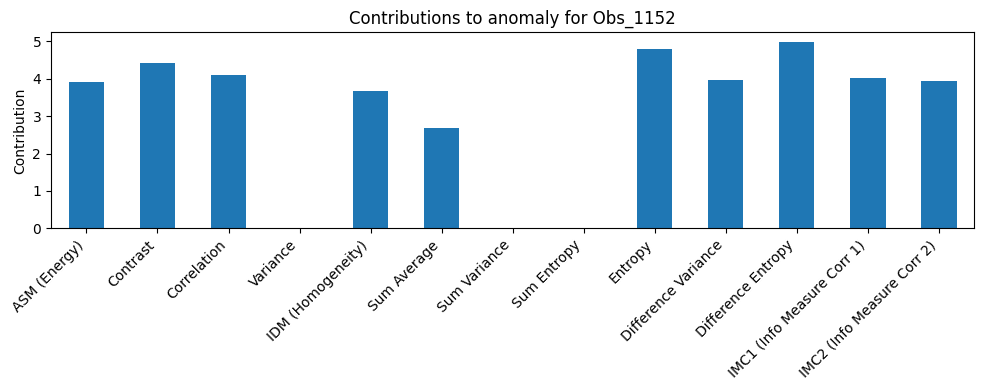

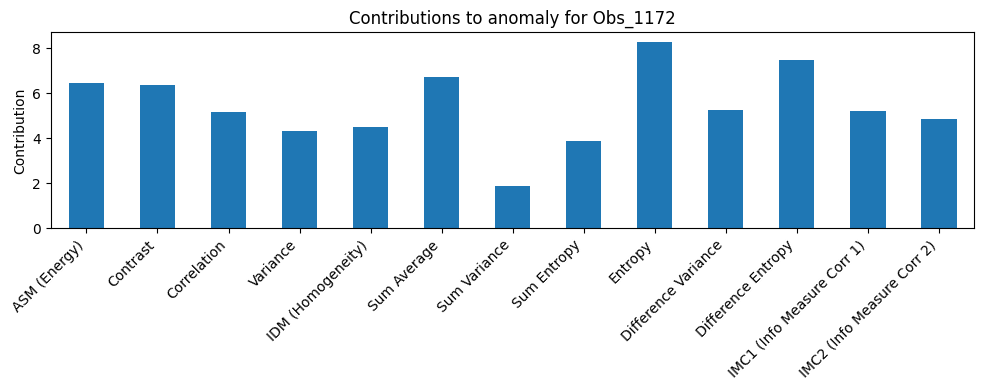

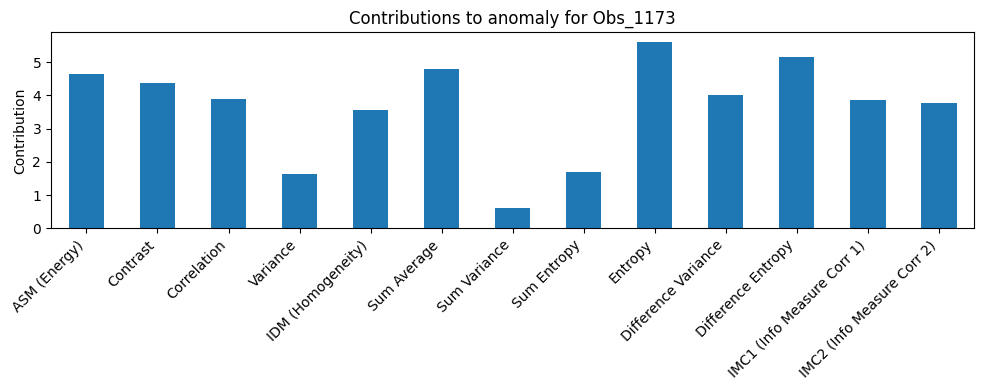

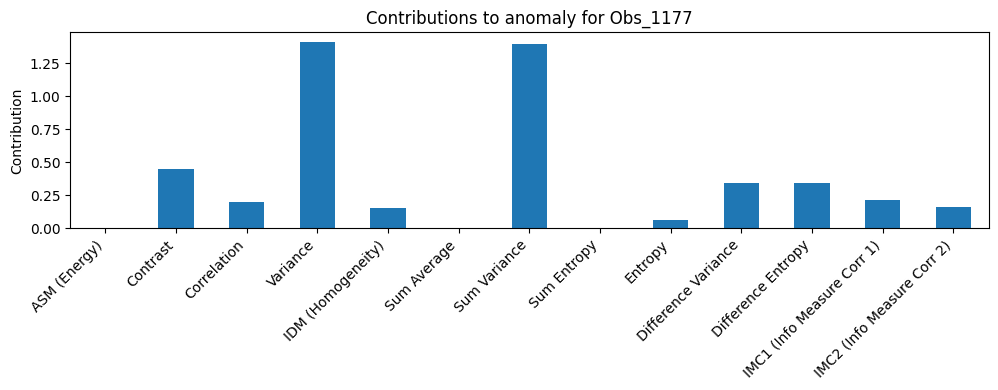

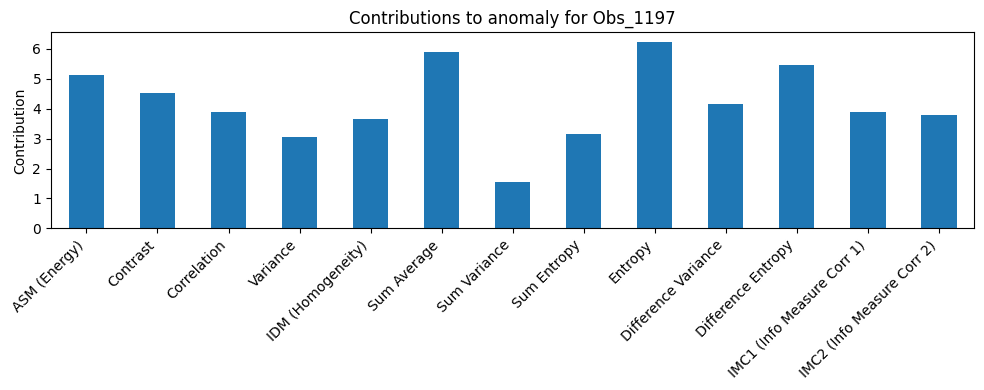

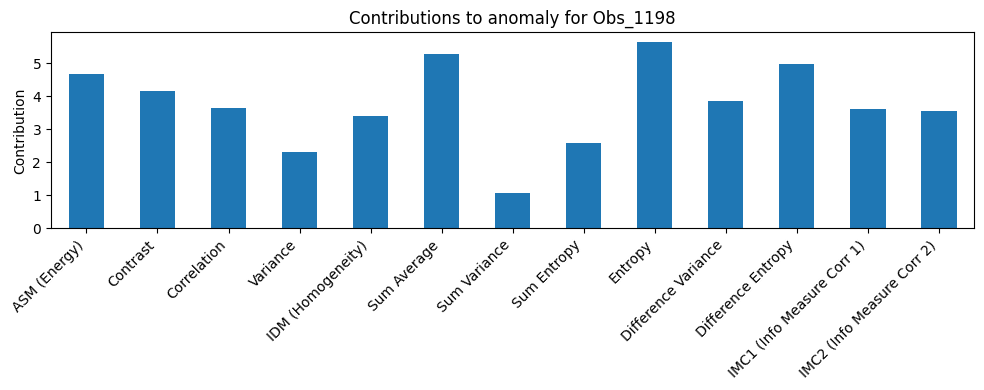

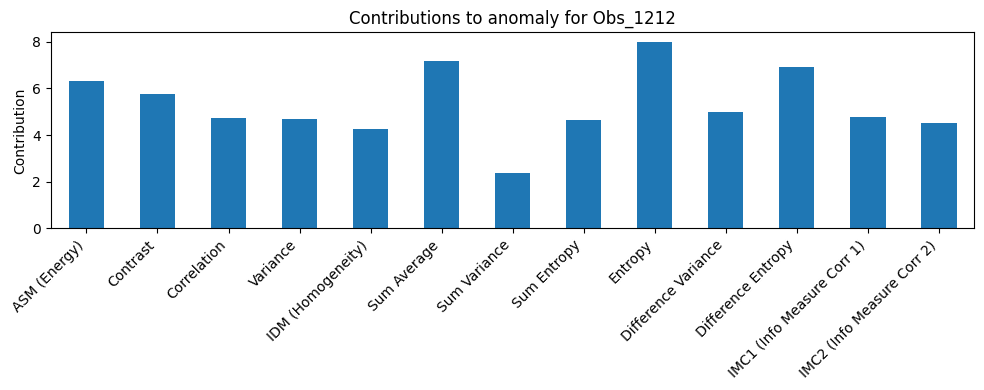

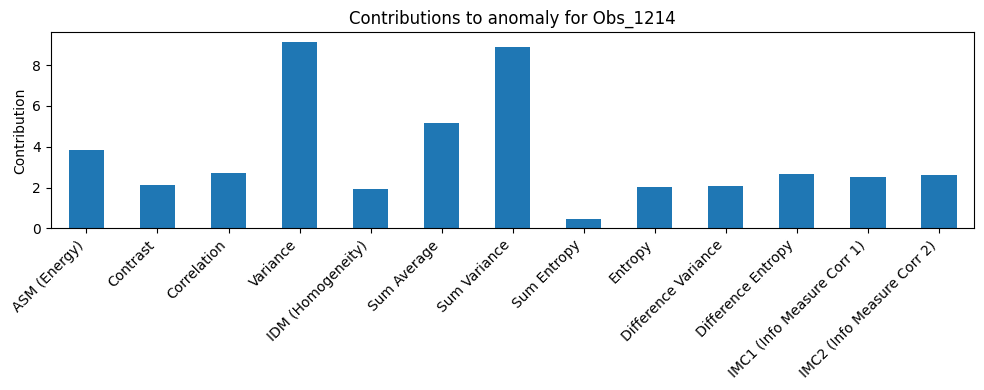

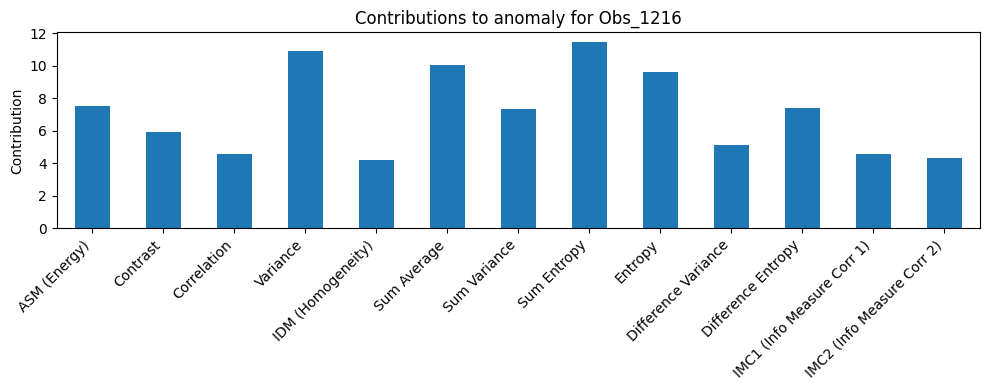

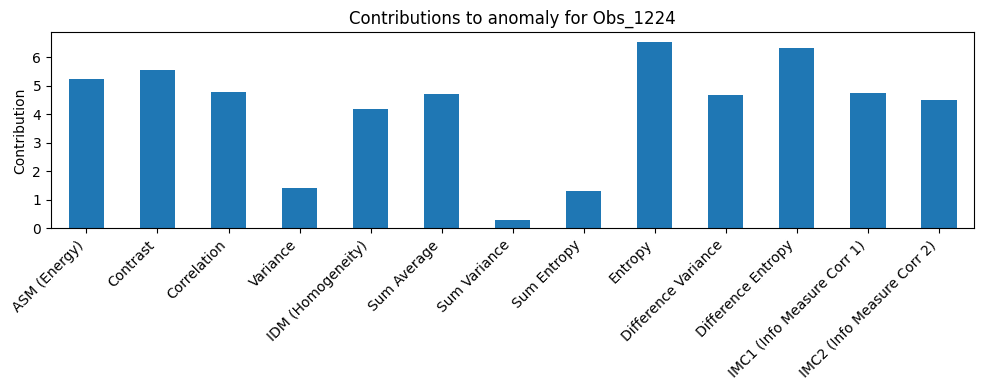

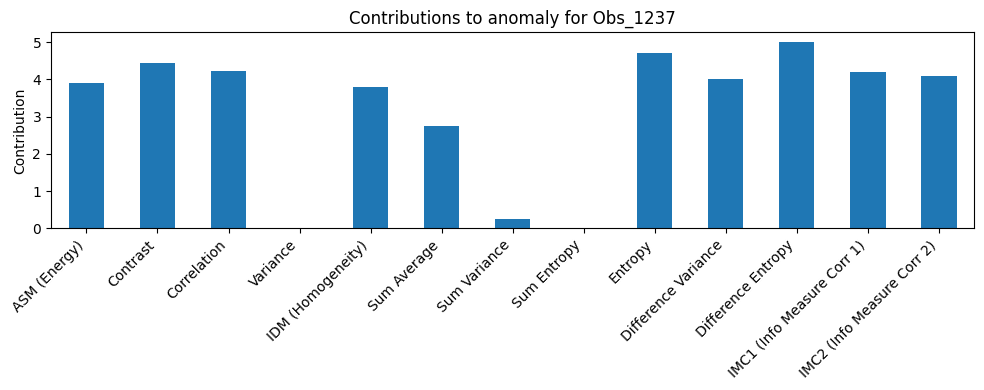

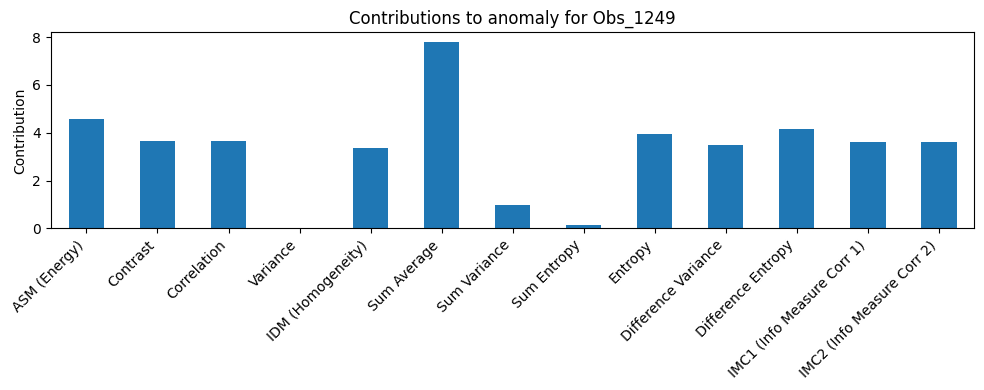

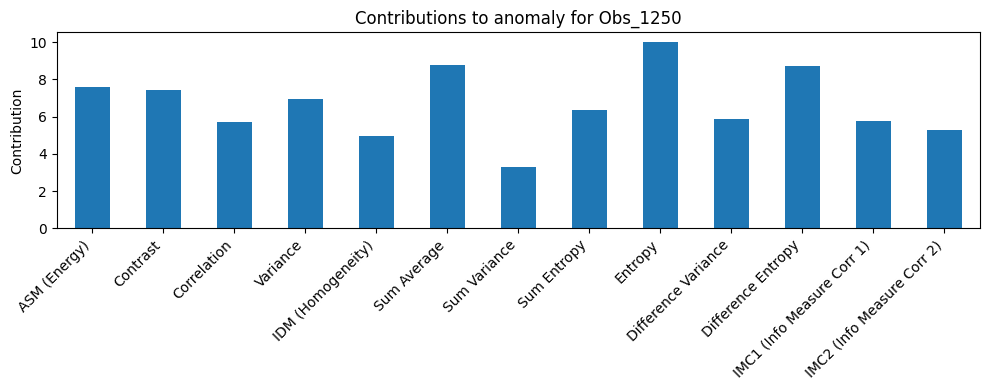

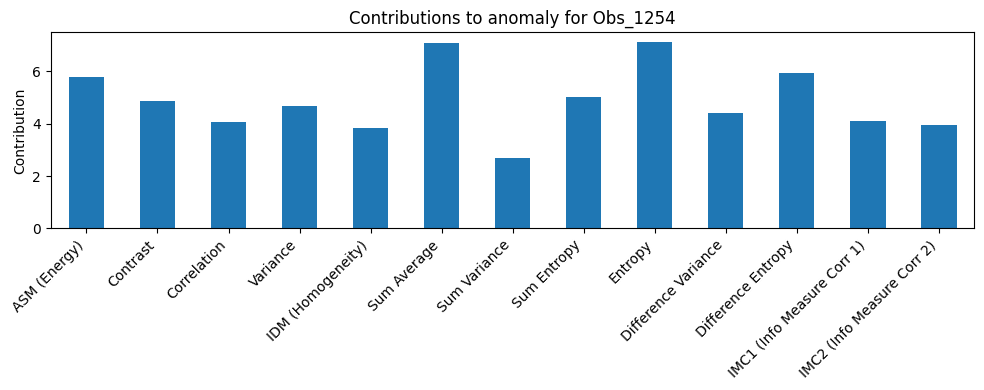

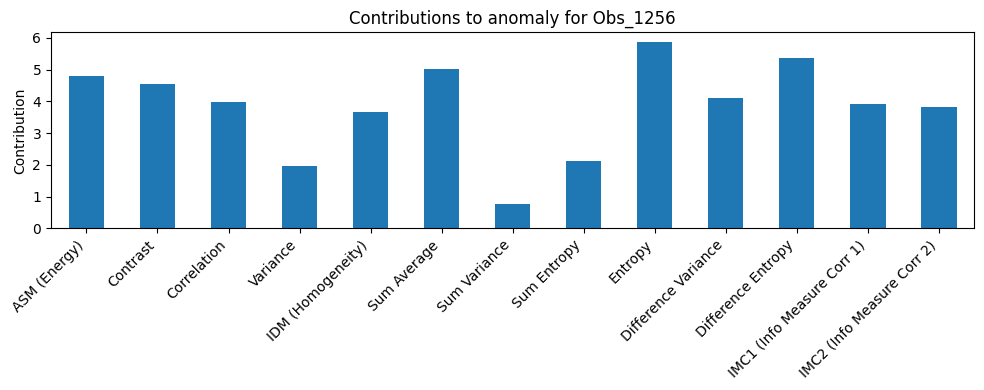

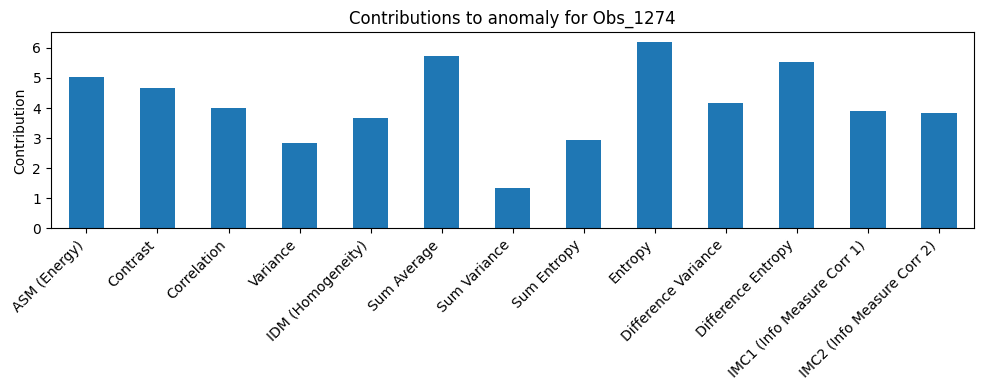

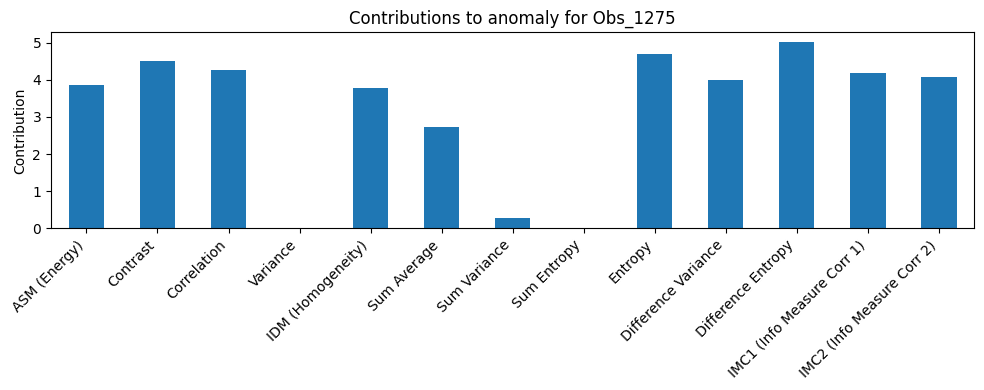

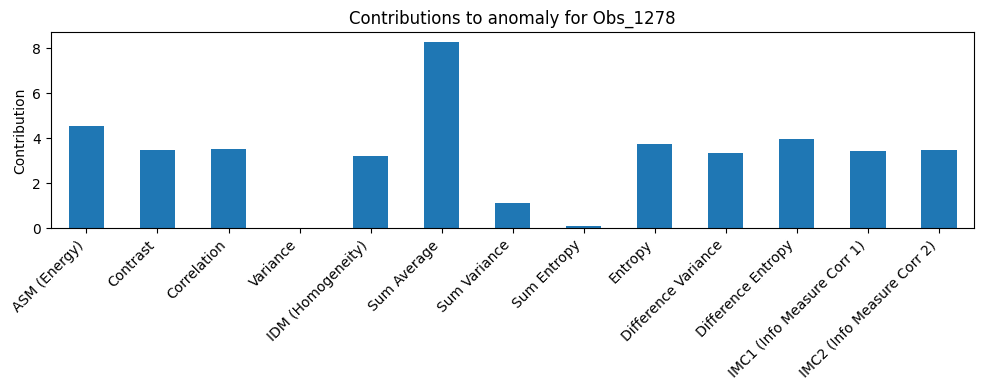

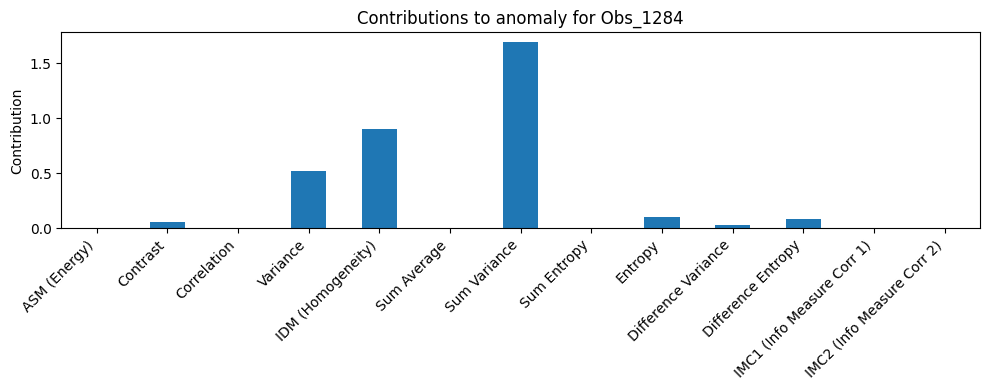

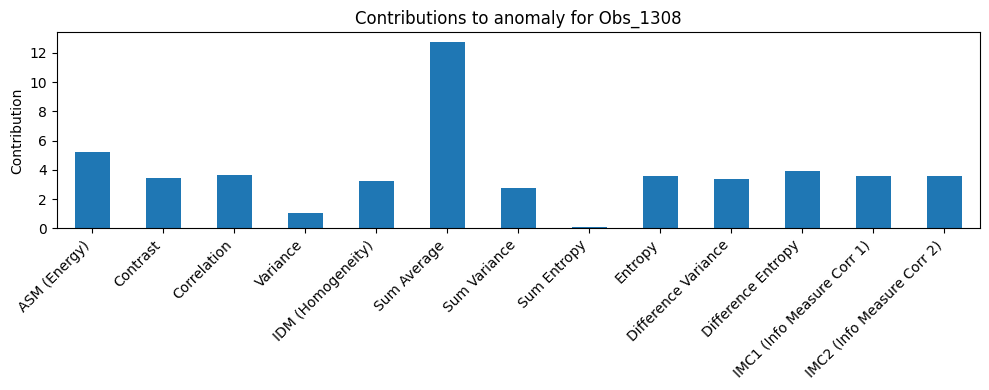

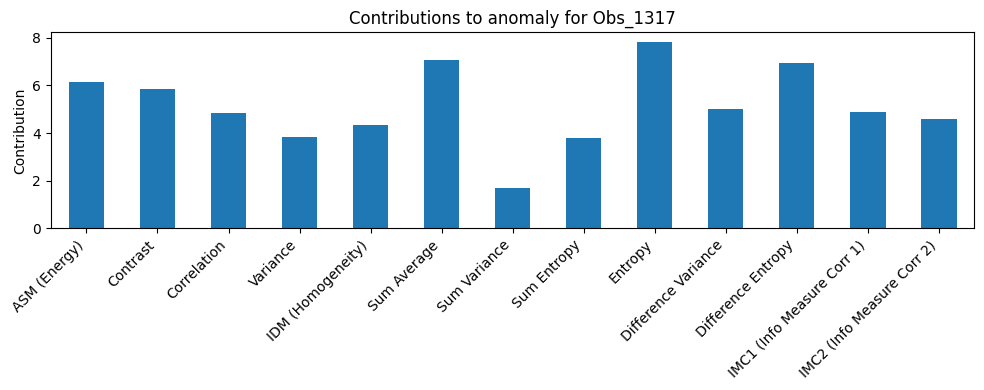

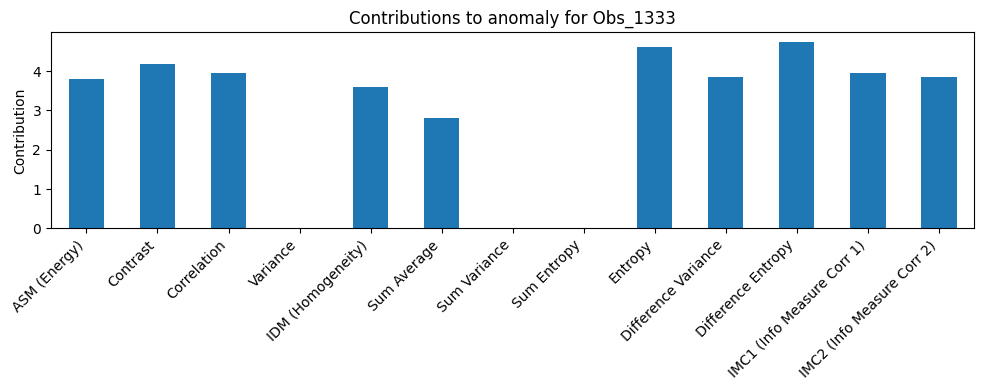

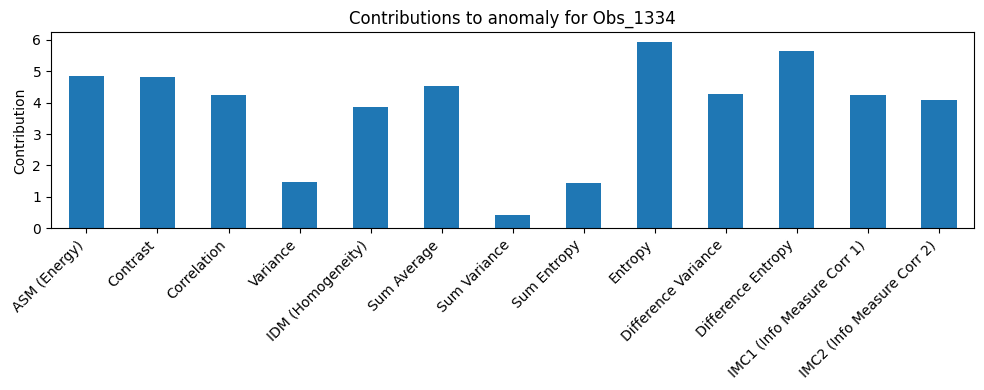

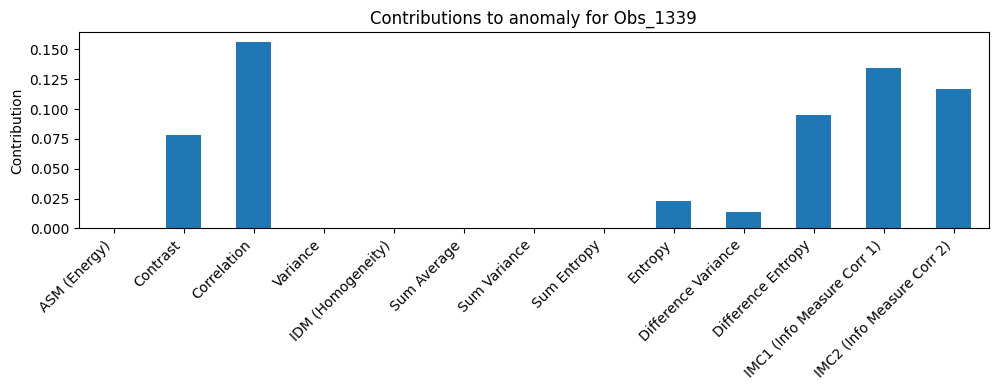

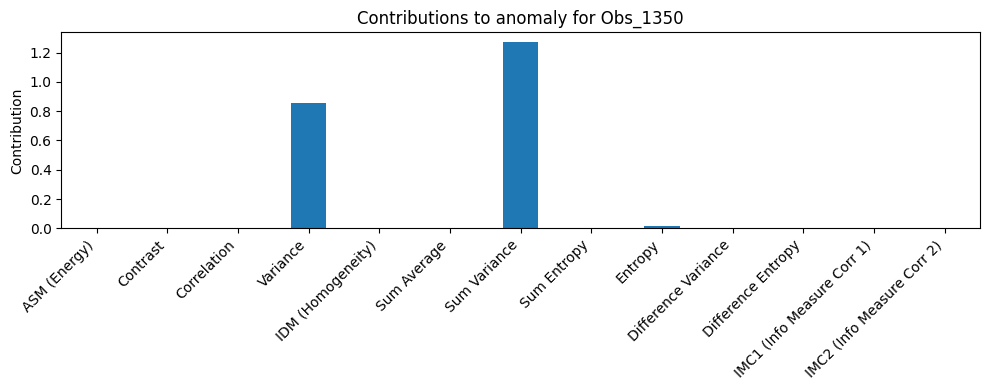

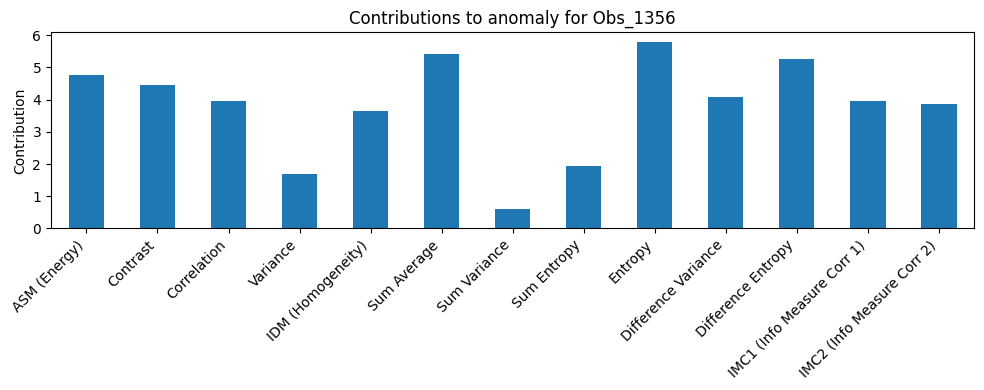

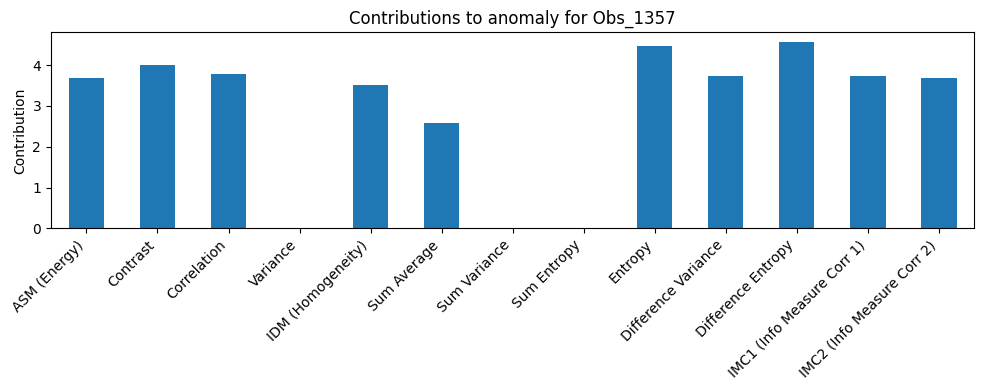

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Supongamos que tienes una lista con los nombres reales de las variables
feature_names = list(X.columns)  # o la lista que corresponda

def contribT2(X, scores, loadings, eigenval, observ, cutoff=2, feature_names=None):
    if isinstance(observ, int):
        observ = [observ]
    
    misScoresNorm = (scores**2) / eigenval
    
    contribs_list = []
    
    for oo in observ:
        misPCs = np.where(misScoresNorm[oo, :] > cutoff)[0]
        
        contribs_pc = []
        for cc in misPCs:
            contri = (scores[oo, cc]**2 / eigenval[cc]) * loadings[:, cc] * X[oo, :]
            contribs_pc.append(contri)
        
        if contribs_pc:
            contribs_sum = np.sum([c * (c > 0) for c in contribs_pc], axis=0)
        else:
            contribs_sum = np.zeros(X.shape[1])
        
        contribs_list.append(contribs_sum)
    
    # Usar nombres reales de variables si se proveen, sino genéricos
    if feature_names is None:
        feature_names = [f'Var{i}' for i in range(X.shape[1])]
        
    contribs = pd.DataFrame(np.array(contribs_list).T, 
                            index=feature_names,
                            columns=[f'Obs_{o}' for o in observ])
    return contribs
eigenval = pca.explained_variance_  # eigenvalores
# Uso ejemplo
contribuciones = contribT2(X_scaled, T, P, eigenval, observ=anomalies, cutoff=2, feature_names=feature_names)

# Ejemplo de uso:

# Supongamos que:
# X_scaled es tu matriz de datos centrados y escalados (numpy array)
# T son los scores PCA ya calculados
# P son los loadings (n_features x n_components)
# eigenval son los eigenvalores asociados (array 1D)
# anomalies contiene los índices de observaciones anómalas

# Para simular eigenval (si no los tienes), puedes usar:
eigenval = pca.explained_variance_  # eigenvalores

# Graficar las contribuciones para cada observación anómala
for obs_col in contribuciones.columns:
    plt.figure(figsize=(10,4))
    contrib = contribuciones[obs_col]
    contrib.plot(kind='bar')
    plt.title(f'Contributions to anomaly for {obs_col}')
    plt.ylabel('Contribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


We cannot remove any of the observations from the dataset because each corresponds to a radish image taken by a CT scanner. These images are unique samples, and excluding them would mean losing valuable information. The anomalous values detected may arise from natural variations in the radishes’ internal structure, slight differences in the scanning process, or noise inherent to the imaging technology. Therefore, rather than discarding these observations, it is important to understand and interpret these anomalies as part of the natural variability in the data.

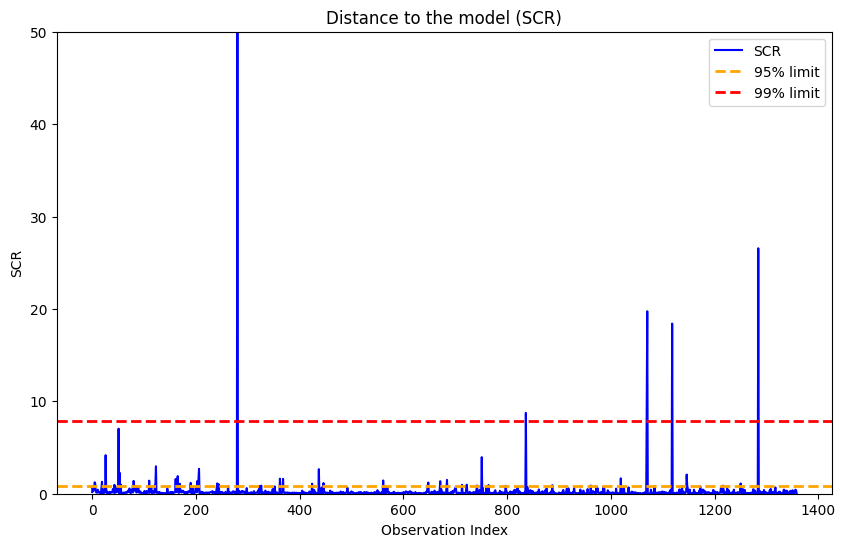

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Supongamos que ya tienes:
# X_scaled: matriz original centrada y escalada (n_samples x n_features)
# T: scores PCA (n_samples x n_components)
# P: loadings PCA (n_features x n_components)

# Reconstrucción del modelo y cálculo del residuo (error)
X_hat = T @ P.T  # Aproximación reconstruida
E = X_scaled - X_hat  # Residuo

# SCR: suma de cuadrados residuales por fila
SCR = np.sum(E**2, axis=1)

# Parámetros para la distribución chi-cuadrado ajustada
var_scr = np.var(SCR, ddof=1)
mean_scr = np.mean(SCR)
g = var_scr / (2 * mean_scr)
h = (2 * mean_scr**2) / var_scr

# Cálculo de los límites para 95% y 99%
chi2_lim_95 = g * chi2.ppf(0.95, df=h)
chi2_lim_99 = g * chi2.ppf(0.99, df=h)

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(range(len(SCR)), SCR, label='SCR', color='blue')
plt.xlabel('Observation Index')
plt.ylabel('SCR')
plt.title('Distance to the model (SCR)')
plt.ylim(0, 50)

plt.axhline(chi2_lim_95, color='orange', linestyle='--', linewidth=2, label='95% limit')
plt.axhline(chi2_lim_99, color='red', linestyle='--', linewidth=2, label='99% limit')

plt.legend()
plt.show()


To ensure that our PCA model is not biased by extreme observations, we will remove all samples whose Squared Prediction Error (SPE/SCR) exceeds the 99% confidence limit. These samples correspond to observations whose Haralick features differ substantially from the majority of the dataset, likely due to image acquisition artifacts or processing errors. By excluding them, we focus the analysis on the typical texture patterns of the radish tomographic images, improving the robustness and interpretability of the results.

In [6]:
import pandas as pd

# Supongamos que ya tienes:
# SCR: array/serie con las distancias al modelo
# limit_99: valor del umbral 99%
# df: DataFrame con las Haralick features

# Identificar índices a excluir
outlier_indices = [i for i, val in enumerate(SCR) if val > chi2_lim_99]

# Excluir las filas correspondientes
df = df.drop(index=outlier_indices).reset_index(drop=True)

print(f"Removed {len(outlier_indices)} outliers above the 99% limit.")


Removed 6 outliers above the 99% limit.


Skewness de cada variable:
 ASM (Energy)                  2.292608
Contrast                      2.629856
Correlation                  -1.999493
Variance                     -0.104245
IDM (Homogeneity)             0.885502
Sum Average                   1.753903
Sum Variance                 -0.251835
Sum Entropy                  -0.730242
Entropy                       0.240670
Difference Variance           0.719669
Difference Entropy            0.405232
IMC1 (Info Measure Corr 1)   -0.261216
IMC2 (Info Measure Corr 2)   -2.007354
dtype: float64
Variables a transformar (|skewness| > 1.0): ['ASM (Energy)', 'Contrast', 'Correlation', 'Sum Average', 'IMC2 (Info Measure Corr 2)']


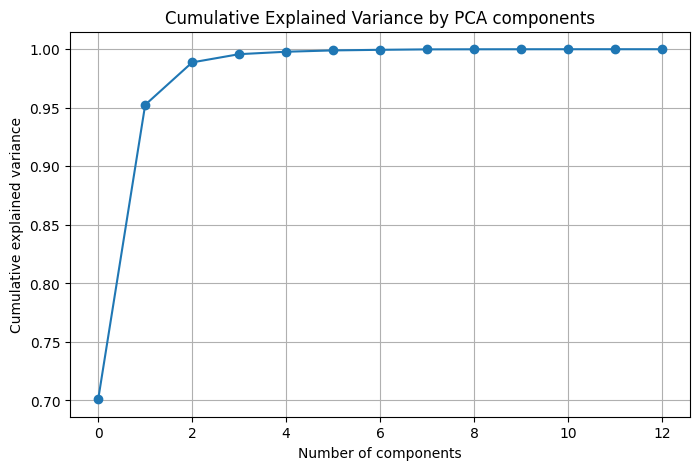

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import skew


features = [
    'ASM (Energy)', 'Contrast', 'Correlation', 'Variance',
    'IDM (Homogeneity)', 'Sum Average', 'Sum Variance', 'Sum Entropy',
    'Entropy', 'Difference Variance', 'Difference Entropy',
    'IMC1 (Info Measure Corr 1)', 'IMC2 (Info Measure Corr 2)'
]
X = df[features].copy()

# === DETECCIÓN DE SKEWNESS ===
skew_vals = X.apply(lambda col: skew(col.dropna()), axis=0)
print("Skewness de cada variable:\n", skew_vals)

# Umbral de asimetría para transformar
threshold = 1.0
vars_to_transform = skew_vals[abs(skew_vals) > threshold].index.tolist()
print(f"Variables a transformar (|skewness| > {threshold}): {vars_to_transform}")

# === TRANSFORMACIÓN YEO–JOHNSON SOLO A VARIABLES SESGADAS ===
if vars_to_transform:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    X[vars_to_transform] = pt.fit_transform(X[vars_to_transform])

# === ESTANDARIZACIÓN ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === PCA ===
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# === VARIANCE EXPLAINED PLOT ===
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance by PCA components')
plt.grid(True)
plt.show()

Indices de observaciones anómalas según Hotelling's T²:
[   4    5    6   26   27   49   53   69   72   82   84   89   93  101
  109  123  145  164  169  175  185  186  206  284  320  322  333  361
  367  435  436  560  653  659  669  670  672  682  698  699  700  712
  720  721  739  740  741  749  750  752  759  763  769  795  796  797
  804  819  835  837  859  872  874  885  906  912  913  916  927  928
  939  953  959  970  972  977  979  983  992 1008 1017 1022 1023 1032
 1040 1067 1073 1111 1127 1132 1141 1142 1143 1147 1160 1165 1167 1168
 1172 1192 1193 1207 1209 1211 1212 1219 1222 1232 1244 1245 1249 1251
 1269 1270 1273 1300 1302 1310 1311 1327 1328 1332 1333 1344 1349 1350
 1351]

Valores T² de las observaciones anómalas:
[10.45792955 13.6489109  12.09963843  9.68915898  8.16135785  9.47816166
  8.465709    9.72500527 16.98646656  8.22311425 14.36169827 11.72840576
 10.31830296 10.80495252  9.61868599 16.15115847  7.90139827 10.49567906
  9.31426043 24.05934181  8.54609236

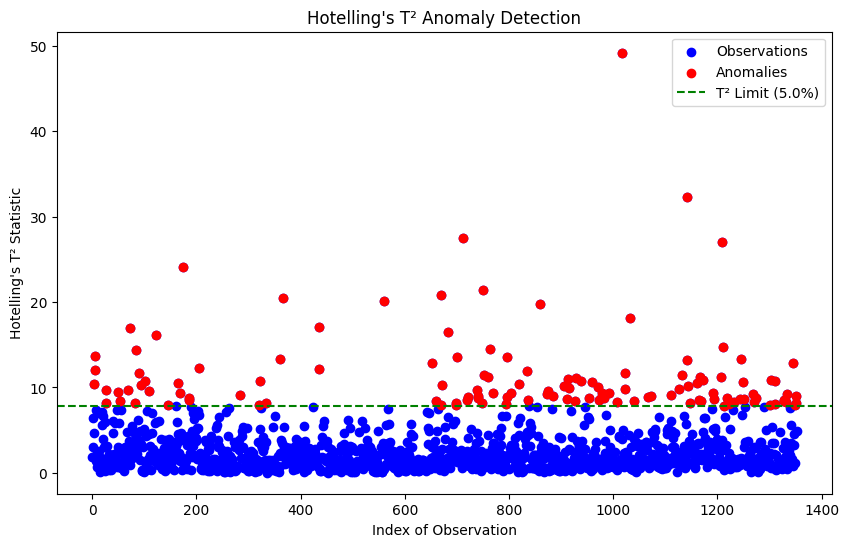

In [8]:
from scipy.stats import f
n_components = 3
pca = PCA(n_components=n_components)
T = pca.fit_transform(X_scaled)  # Scores (t)
P = pca.components_.T            # Loadings (p)

# === 3. Hotelling's T² ===
T2 = np.sum((T / np.std(T, axis=0))**2, axis=1)
n = X_scaled.shape[0]
alpha = 0.05
T2_limit = n_components * (n - 1) / (n - n_components) * f.ppf(1 - alpha, n_components, n - n_components)

# Identificar anomalías: T² mayor que el límite
anomalies = np.where(T2 > T2_limit)[0]

print("Indices de observaciones anómalas según Hotelling's T²:")
print(anomalies)

# Opcionalmente, imprimir los valores T² de esas observaciones
print("\nValores T² de las observaciones anómalas:")
print(T2[anomalies])

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Todos los puntos
plt.scatter(range(len(T2)), T2, label='Observations', color='blue')

# Puntos anómalos en rojo
plt.scatter(anomalies, T2[anomalies], color='red', label='Anomalies')

# Línea límite
plt.axhline(y=T2_limit, color='green', linestyle='--', label=f'T² Limit ({alpha*100:.1f}%)')

plt.xlabel('Index of Observation')
plt.ylabel("Hotelling's T² Statistic")
plt.title("Hotelling's T² Anomaly Detection")
plt.legend()
plt.show()

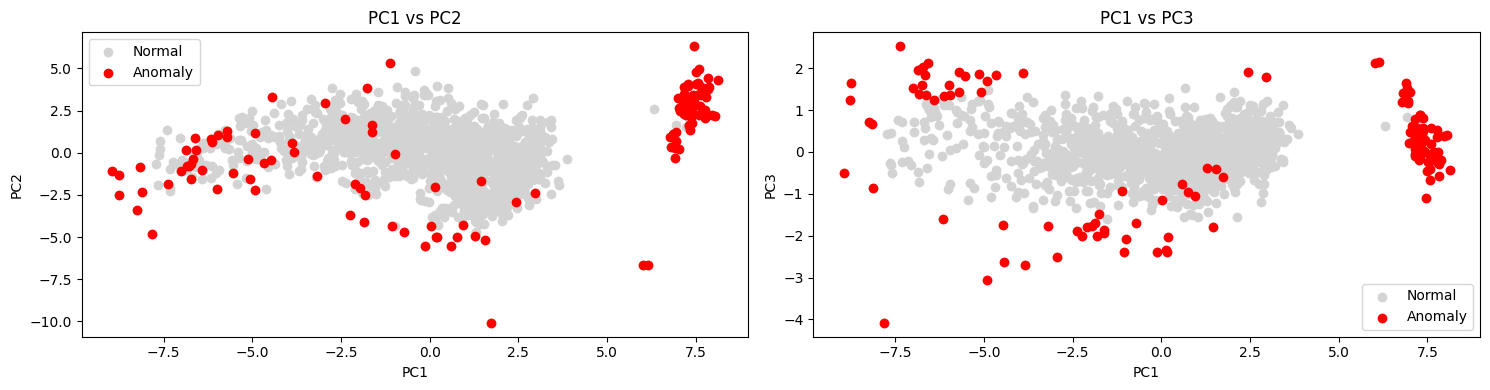

In [9]:
import matplotlib.pyplot as plt

# Número de componentes
n_components = 3

# Scores de PCA ya calculados: T (shape: n_samples x n_components)
# Índices de anomalías ya definidos: anomalies

plt.figure(figsize=(15, 4))

for i in range(1, n_components):
    plt.subplot(1, n_components-1, i)
    
    # Todos los puntos en gris claro
    plt.scatter(T[:, 0], T[:, i], color='lightgray', label='Normal')
    
    # Puntos anómalos en rojo
    plt.scatter(T[anomalies, 0], T[anomalies, i], color='red', label='Anomaly')
    
    plt.xlabel('PC1')
    plt.ylabel(f'PC{i+1}')
    plt.title(f'PC1 vs PC{i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

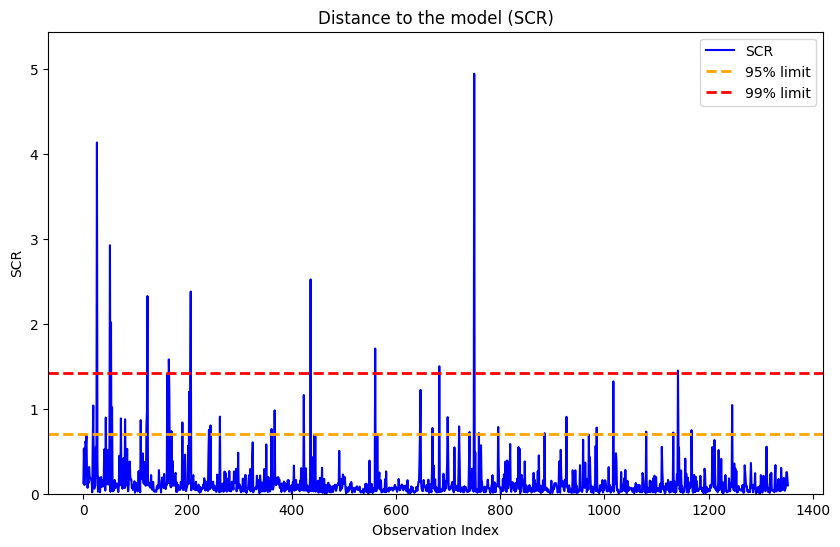

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Reconstrucción del modelo y cálculo del residuo (error)
X_hat = T @ P.T
E = X_scaled - X_hat

# SCR: suma de cuadrados residuales por fila
SCR = np.sum(E**2, axis=1)

# Parámetros para la distribución chi-cuadrado ajustada
var_scr = np.var(SCR, ddof=1)
mean_scr = np.mean(SCR)
g = var_scr / (2 * mean_scr)
h = (2 * mean_scr**2) / var_scr

# Cálculo de los límites para 95% y 99%
chi2_lim_95 = g * chi2.ppf(0.95, df=h)
chi2_lim_99 = g * chi2.ppf(0.99, df=h)

# Gráfico con escala vertical ajustada
plt.figure(figsize=(10,6))
plt.plot(range(len(SCR)), SCR, label='SCR', color='blue')
plt.xlabel('Observation Index')
plt.ylabel('SCR')
plt.title('Distance to the model (SCR)')

# Ajustar el eje y al máximo valor de SCR + margen
max_scr = SCR.max()
plt.ylim(0, max_scr * 1.1)

plt.axhline(chi2_lim_95, color='orange', linestyle='--', linewidth=2, label='95% limit')
plt.axhline(chi2_lim_99, color='red', linestyle='--', linewidth=2, label='99% limit')

plt.legend()
plt.show()



By removing the anomalous data, the PCA results improve noticeably. The vertical scale of the residual plot is now smaller and even acceptable, considering that the images used contain a high level of noise. This suggests that the anomalies were significantly inflating the residual variance and that their removal leads to a model that better represents the general structure of the data.

C:\Users\ritaj\AppData\Local\Temp\ipykernel_9908\4242936499.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlBu_r')


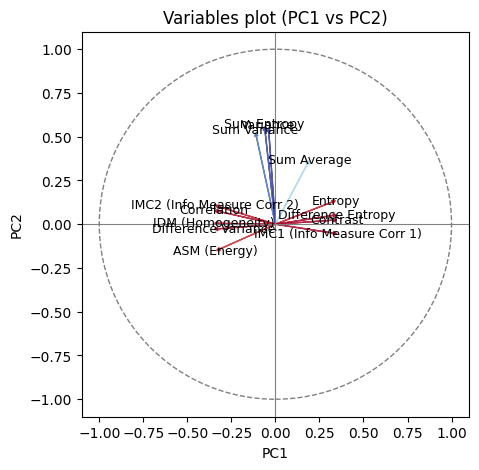

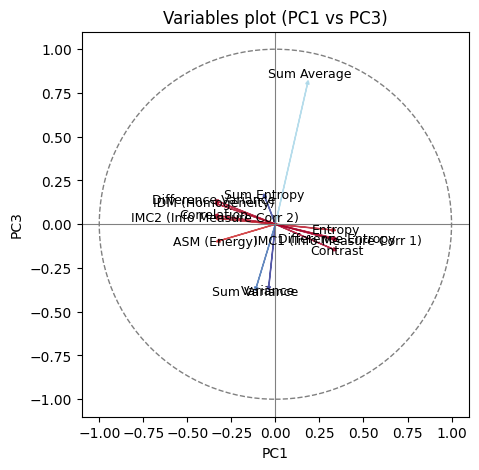

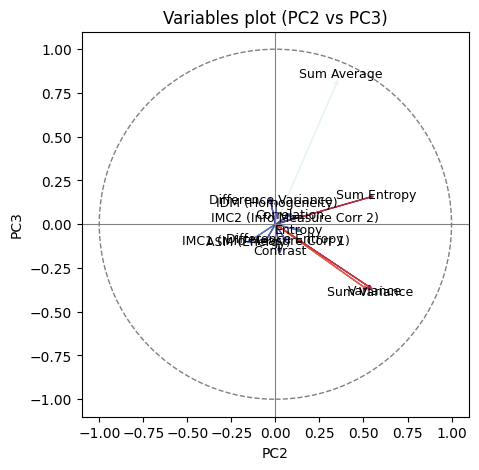

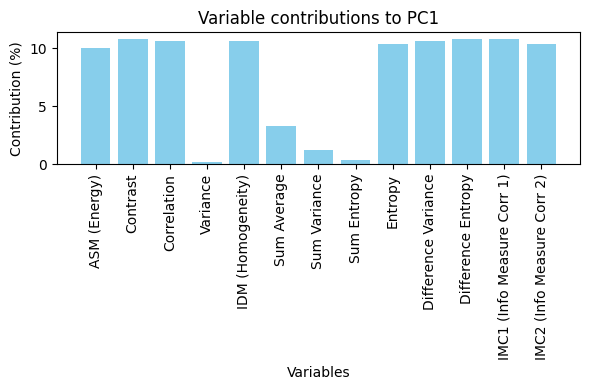

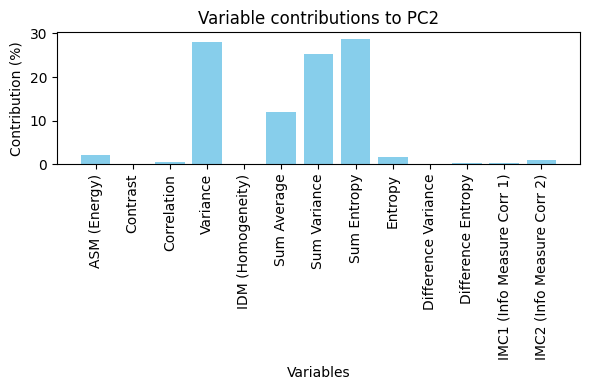

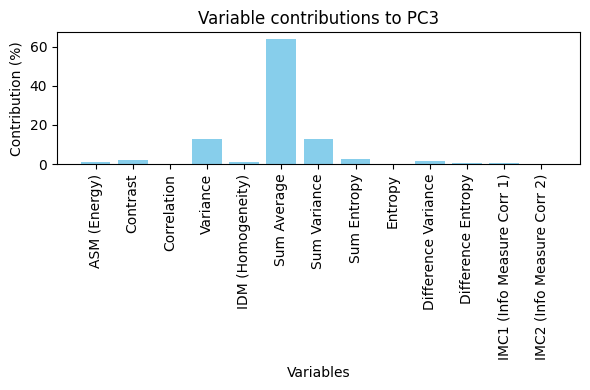

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_pca_var(pcx, pcy, features, loadings, contrib):
    """Gráfico tipo fviz_pca_var para dos componentes principales."""
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Colores según contribución
    cmap = cm.get_cmap('RdYlBu_r')
    norm = plt.Normalize(contrib[:, pcx].min(), contrib[:, pcx].max())
    
    # Flechas y nombres
    for i, var in enumerate(features):
        ax.arrow(0, 0,
                 loadings[i, pcx], loadings[i, pcy],
                 color=cmap(norm(contrib[i, pcx])),
                 alpha=0.8, head_width=0.02, head_length=0.02)
        ax.text(loadings[i, pcx]*1.07, loadings[i, pcy]*1.07,
                var, ha='center', va='center', fontsize=9)
    
    # Círculo unidad
    circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    ax.axhline(0, color='gray', linewidth=0.8)
    ax.axvline(0, color='gray', linewidth=0.8)
    ax.set_xlabel(f'PC{pcx+1}')
    ax.set_ylabel(f'PC{pcy+1}')
    ax.set_title(f'Variables plot (PC{pcx+1} vs PC{pcy+1})')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    plt.show()

def plot_contrib(comp, features, contrib):
    """Gráfico tipo fviz_contrib para un componente."""
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(features, contrib[:, comp], color='skyblue')
    ax.set_ylabel('Contribution (%)')
    ax.set_xlabel('Variables')
    ax.set_title(f'Variable contributions to PC{comp+1}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# === Preparar loadings y contribuciones ===
# P: loadings del PCA
# pca: objeto PCA entrenado
P = pca.components_.T
explained_var = pca.explained_variance_ratio_

# Contribución de cada variable a cada componente (en %)
contrib = (P**2)
contrib = contrib / contrib.sum(axis=0)
contrib = contrib * 100

# Generar pares válidos según el nº de componentes
n_comp = P.shape[1]
pairs = [(i, j) for i in range(n_comp) for j in range(i+1, n_comp)]

# === Gráficos de variables ===
for pcx, pcy in pairs:
    plot_pca_var(pcx, pcy, features, P, contrib)

# === Gráficos de contribución por componente ===
for comp in range(n_comp):
    plot_contrib(comp, features, contrib)



The contribution plots reveal that different variables dominate the first three principal components of the PCA model.
For PC1, the contributions are relatively balanced across most variables, with features such as *Contrast*, *Correlation*, *IDM (Homogeneity)*, and *IMC measures* showing similar importance levels. This suggests that PC1 captures a general trend or combination of multiple texture descriptors rather than being dominated by a single variable.
In contrast, PC2 displays a much more selective influence, with *Variance*, *Sum Variance*, and *Sum Entropy* contributing the most, indicating that this component is strongly associated with variability and entropy-related features.

PC3, however, is heavily dominated by *Sum Average*, which accounts for more than 60% of its variance contribution. This overwhelming influence implies that PC3 primarily reflects changes in this single feature, with other variables playing a marginal role. Such a pattern could indicate that *Sum Average* captures a unique aspect of the dataset that is largely independent from the trends in PC1 and PC2. This also suggests that PC3’s interpretability is straightforward, as it is largely driven by a single measurement rather than a complex combination of features.


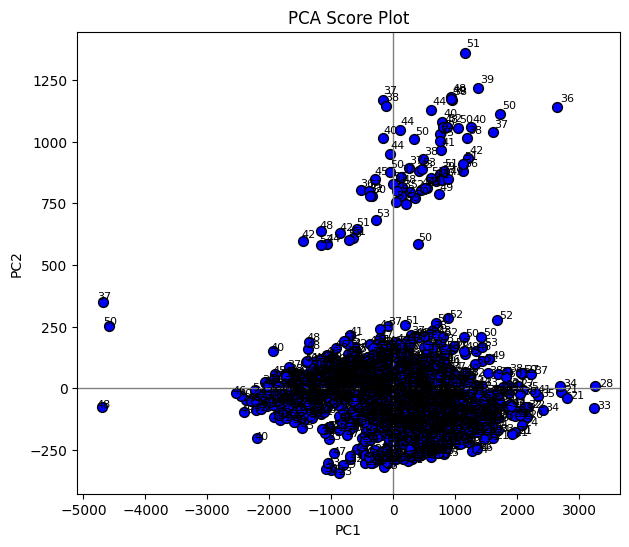

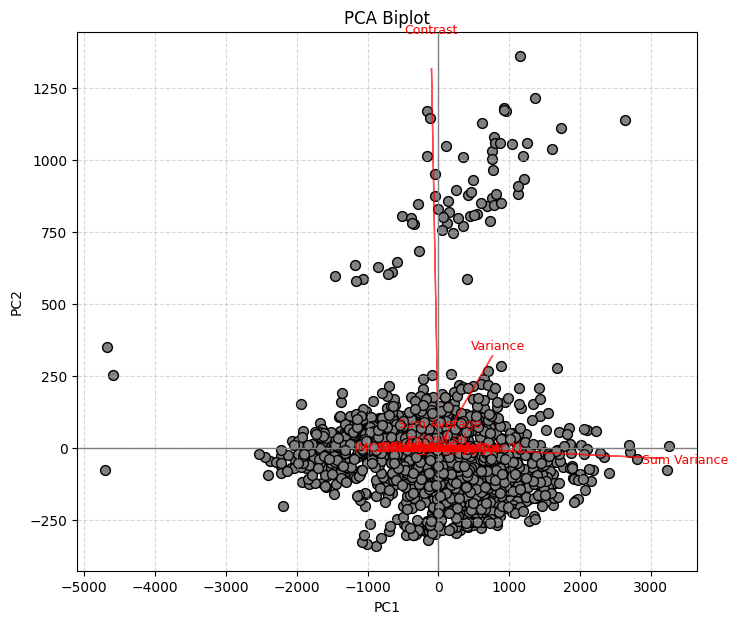

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# === Preparar datos ===
# X solo con columnas numéricas
X = df.select_dtypes(include=np.number).values
# Lista de nombres para etiquetas
lista_nombres = df["individual"].tolist()
# Nombres de las features
feature_names = df.select_dtypes(include=np.number).columns.tolist()

# Ajustar PCA
pca = PCA(n_components=min(X.shape[0], X.shape[1]))
pca.fit(X)
scores = pca.transform(X)

# === Función para score plot ===
def plot_pca_scores(scores, pcx=0, pcy=1, labels=None, title="PCA Score Plot"):
    plt.figure(figsize=(7,6))
    plt.scatter(scores[:, pcx], scores[:, pcy], c='blue', edgecolor='k', s=50)

    if labels is not None:
        for i, txt in enumerate(labels):
            plt.text(scores[i, pcx]*1.02, scores[i, pcy]*1.02, txt, fontsize=8)

    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.xlabel(f"PC{pcx+1}")
    plt.ylabel(f"PC{pcy+1}")
    plt.title(title)
    plt.show()

# === Función para biplot ===
def pca_biplot(scores, loadings, features, pcx=0, pcy=1, title="PCA Biplot"):
    plt.figure(figsize=(8,7))
    
    # Puntos de observaciones
    plt.scatter(scores[:, pcx], scores[:, pcy], c='grey', s=50, edgecolor='k')

    # Flechas y nombres de variables
    for i, var in enumerate(features):
        plt.arrow(0, 0, loadings[i, pcx]*max(scores[:, pcx]),
                  loadings[i, pcy]*max(scores[:, pcy]),
                  color='red', alpha=0.7, head_width=0.02, head_length=0.02)
        plt.text(loadings[i, pcx]*max(scores[:, pcx])*1.1,
                 loadings[i, pcy]*max(scores[:, pcy])*1.1,
                 var, color='red', ha='center', va='center', fontsize=9)

    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.xlabel(f"PC{pcx+1}")
    plt.ylabel(f"PC{pcy+1}")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# === Ejemplo de uso ===
plot_pca_scores(scores, 0, 1, labels=lista_nombres)
pca_biplot(scores, pca.components_.T, feature_names, 0, 1)



In the **PCA Score Plot**, most observations form a dense cluster around the origin, indicating that they share relatively homogeneous Haralick feature patterns. However, there are distinct groups dispersed away from the main cluster, particularly towards higher PC2 values, which represent significant variations in texture captured by the PCA. The clear separation of these groups suggests the existence of subpopulations of radish images with markedly different texture characteristics, possibly associated with varying dehydration stages or specific sample conditions.

In the **PCA Biplot**, the arrows represent the contribution of each original variable (Haralick features) to the principal components. Some variables, such as *Contrast*, show a strong projection on PC2, indicating a high influence on the vertical separation seen in the score plot. Others, such as *Sum Variance*, are more aligned with PC1, contributing to the horizontal dispersion. This confirms that the textural differences captured by these metrics are the main drivers of variability among samples, and that the PCA effectively distinguishes between common texture patterns and those exhibiting atypical characteristics.


# Conclusions

The correlation matrix revealed that the Haralick features are highly collinear, with several pairs showing correlation coefficients above 0.95 in absolute value. Such strong multicollinearity can severely affect the stability and reliability of a multiple regression model, leading to unstable coefficients, inflated standard errors, and poor interpretability of individual predictors. By applying Principal Component Analysis (PCA), we transform the original correlated features into a smaller set of uncorrelated components that capture most of the variance in the data. This approach improves model stability, reduces overfitting risk, and preserves the most relevant information for prediction, even though it sacrifices direct interpretability of the original variables. For this reason, the regression model will be built using the PCA components instead of the raw Haralick features.

# Linear Regression

The PCA previously computed cannot be used directly for model evaluation because it was fitted using the entire dataset before splitting into training and test sets. This introduces data leakage, as the PCA components already contain information from the test data, leading to overly optimistic performance estimates. For a fair evaluation, PCA must be fitted only on the training data, and then the same transformation should be applied to the test set before regression modeling.


                            OLS Regression Results                            
Dep. Variable:       water_percentage   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     6372.
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:35:34   Log-Likelihood:                 2209.2
No. Observations:                1082   AIC:                            -4410.
Df Residuals:                    1078   BIC:                            -4390.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8016      0.001    837.953      0.0

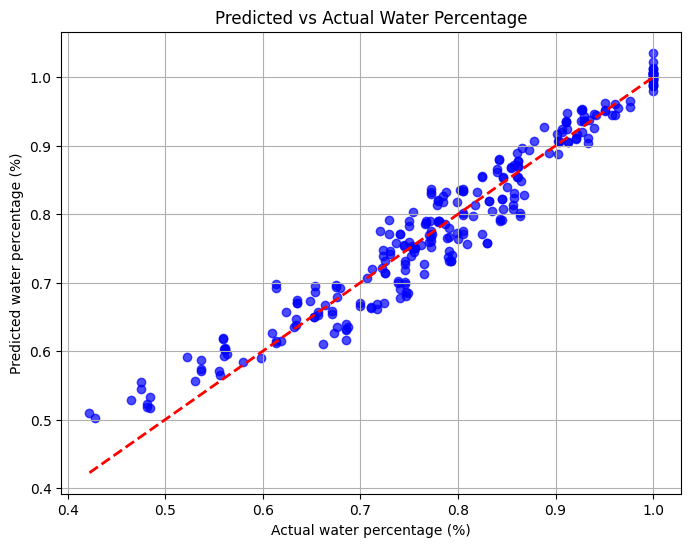

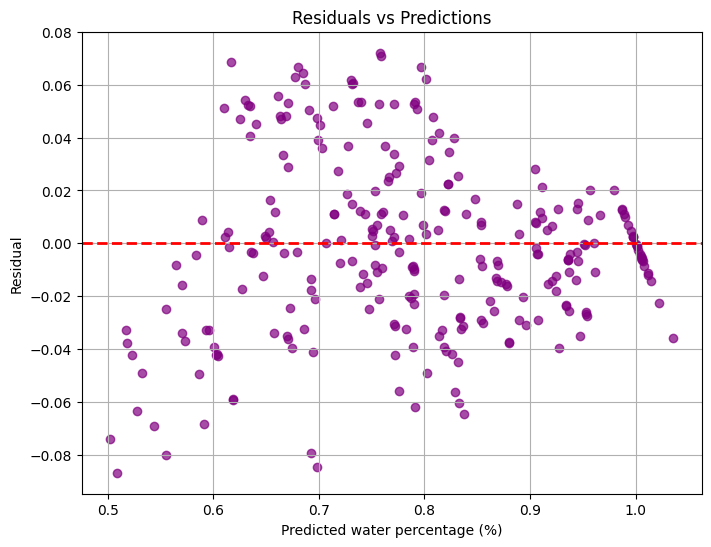

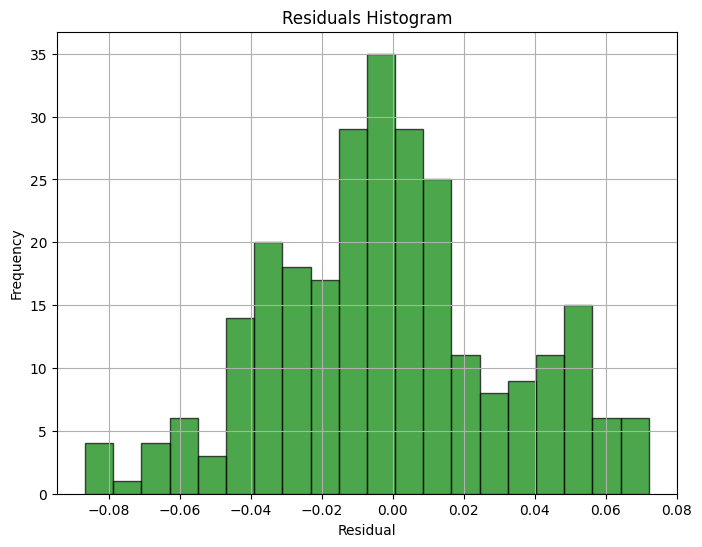

Mean of residuals: -0.0015907502786374319
Standard deviation of residuals: 0.03281297405688727


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# -------------------
# Seed
# -------------------
SEED = 42
np.random.seed(SEED)

# -------------------
# Target
# -------------------
y = df["water_percentage"]

# -------------------
# Train-test split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# -------------------
# Scaling
# -------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------
# PCA
# -------------------
n_components = 3
pca = PCA(n_components=n_components, random_state=SEED)
T_train = pca.fit_transform(X_train_scaled)
T_test = pca.transform(X_test_scaled)

# -------------------
# Fit OLS model using statsmodels
# -------------------
T_train_sm = sm.add_constant(T_train)
model = sm.OLS(y_train, T_train_sm)
results = model.fit()

# -------------------
# Summary
# -------------------
print(results.summary())

# -------------------
# Prediction
# -------------------
T_test_sm = sm.add_constant(T_test)
y_pred = results.predict(T_test_sm)

# -------------------
# Evaluation
# -------------------
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nR² (test): {r2:.4f}")
print(f"RMSE (test): {rmse:.4f}")

# -------------------
# Prediction vs Actual plot
# -------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual water percentage (%)")
plt.ylabel("Predicted water percentage (%)")
plt.title("Predicted vs Actual Water Percentage")
plt.grid(True)
plt.show()

# -------------------
# Residuals
# -------------------
residuals = y_test - y_pred

# Residuals vs Prediction plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.7)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted water percentage (%)")
plt.ylabel("Residual")
plt.title("Residuals vs Predictions")
plt.grid(True)
plt.show()

# Residuals histogram
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.grid(True)
plt.show()

# Basic residual statistics
print("Mean of residuals:", np.mean(residuals))
print("Standard deviation of residuals:", np.std(residuals))


The regression model demonstrates an excellent fit to the data, with an R² of 0.947 and an adjusted R² of 0.946, indicating that approximately 94.7% of the variability in *water\_percentage* is explained by the predictors. The performance remains consistent on the test set, with an R² of 0.940, suggesting minimal overfitting. Additionally, the RMSE on the test set is 0.0329, reflecting a very low prediction error. The F-statistic’s p-value is effectively zero, confirming that the model as a whole is statistically significant.

All predictors (*x1*, *x2*, and *x3*) are highly significant, with p-values well below 0.001. The estimated coefficients reveal that *x1* has a small but significant negative effect on *water\_percentage* (-0.0052), while *x2* (0.0327) and *x3* (0.0888) both have positive impacts. In particular, *x3* exhibits the largest effect among the predictors, indicating a stronger relationship with the dependent variable. The intercept of 0.8016 represents the expected *water\_percentage* when all predictors are zero.

Diagnostic statistics support the validity of the model assumptions. The Durbin–Watson statistic (2.075) suggests no autocorrelation in residuals, while the Omnibus and Jarque–Bera tests (p-values of 0.910 and 0.893, respectively) indicate no significant deviation from normality. The residual distribution is close to symmetric (skew = -0.030) with near-normal kurtosis (2.963). Furthermore, the low condition number (3.04) suggests the absence of problematic multicollinearity. Overall, the model is both statistically robust and highly predictive.

Regarding the residual analysis, the scatterplot of residuals versus predictions shows no clear systematic pattern, which supports the assumption of homoscedasticity. The residuals are well distributed around zero, without evidence of strong biases across the prediction range. The histogram of residuals further confirms approximate normality, with a bell-shaped distribution centered near zero. The mean of the residuals (-0.0016) is practically zero, and the standard deviation (0.0328) matches the RMSE, reflecting a tight clustering of errors around the true values. Together, these results suggest that the model’s errors are small, randomly distributed, and consistent with the assumptions of linear regression.

Overall, the model is both statistically robust and highly predictive, with residual diagnostics reinforcing the reliability of the results.

# Comparation with Random Forest

[I 2025-08-21 12:44:43,806] A new study created in memory with name: no-name-3a2c833e-6d01-4476-93c4-77f69aa2012c
[I 2025-08-21 12:44:46,850] Trial 5 finished with value: 0.8979154298302288 and parameters: {'n_estimators': 83, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 5 with value: 0.8979154298302288.
[I 2025-08-21 12:44:47,544] Trial 2 finished with value: 0.8950543047426657 and parameters: {'n_estimators': 138, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 5 with value: 0.8979154298302288.
[I 2025-08-21 12:44:48,373] Trial 3 finished with value: 0.9142240218484833 and parameters: {'n_estimators': 263, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.9142240218484833.
[I 2025-08-21 12:44:48,485] Trial 1 finished with value: 0.9140154677094718 and parameters: {'n_estimators': 325, 'max_depth': 18, 'm


📌 Mejor configuración RF (PCA): {'n_estimators': 487, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

📌 Random Forest (PCA) Results:
R² test: 0.9203
RMSE:    0.0379
MAE:     0.0287


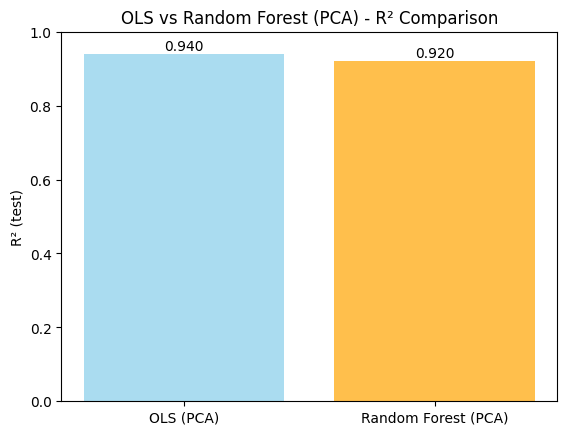

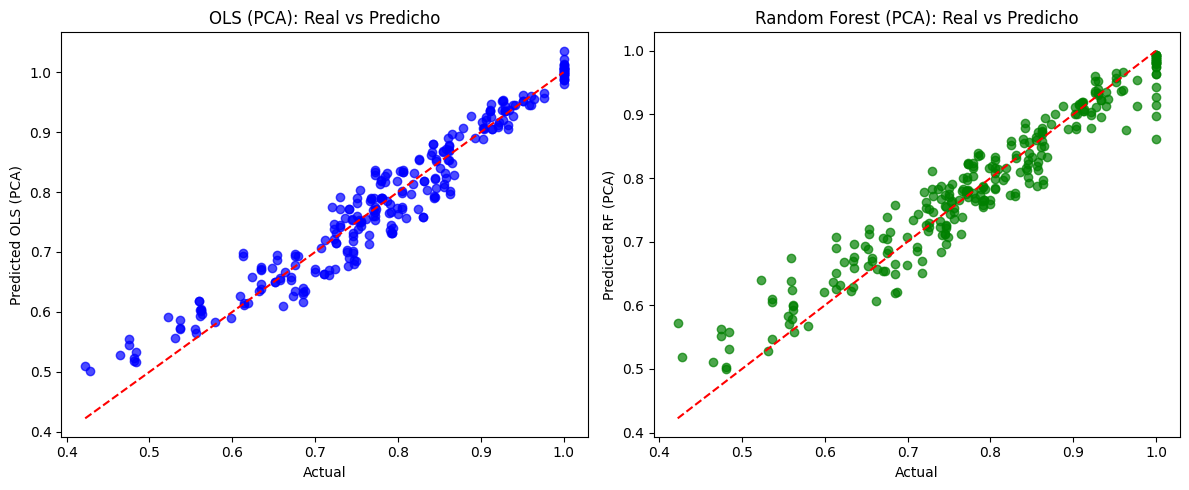

In [15]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ==========================
# Optuna para RF con PCA
# ==========================
def objective_rf_pca(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        max_depth=trial.suggest_int("max_depth", 2, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        random_state=SEED,
        n_jobs=-1
    )
    rf.fit(T_train, y_train)
    y_pred = rf.predict(T_test)
    return r2_score(y_test, y_pred)

# Estudio Optuna
study_rf_pca = optuna.create_study(direction="maximize")
study_rf_pca.optimize(objective_rf_pca, n_trials=50, n_jobs=-1)

print("\n📌 Mejor configuración RF (PCA):", study_rf_pca.best_params)

# Entrenamos modelo final con los mejores hiperparámetros
rf_pca = RandomForestRegressor(**study_rf_pca.best_params, random_state=SEED, n_jobs=-1)
rf_pca.fit(T_train, y_train)
y_pred_rf_pca = rf_pca.predict(T_test)

# ==========================
# Métricas RF (PCA)
# ==========================
mse_rf_pca = mean_squared_error(y_test, y_pred_rf_pca)
rmse_rf_pca = np.sqrt(mse_rf_pca)
mae_rf_pca = mean_absolute_error(y_test, y_pred_rf_pca)
r2_rf_pca = r2_score(y_test, y_pred_rf_pca)

print("\n📌 Random Forest (PCA) Results:")
print(f"R² test: {r2_rf_pca:.4f}")
print(f"RMSE:    {rmse_rf_pca:.4f}")
print(f"MAE:     {mae_rf_pca:.4f}")

# ==========================
# Comparación OLS vs RF (PCA)
# ==========================
labels = ["OLS (PCA)", "Random Forest (PCA)"]
r2_values = [r2, r2_rf_pca]  # r2 viene de tu bloque de OLS arriba

plt.bar(labels, r2_values, color=['skyblue', 'orange'], alpha=0.7)
plt.ylabel("R² (test)")
plt.ylim(0, 1)
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.title("OLS vs Random Forest (PCA) - R² Comparison")
plt.show()

# ==========================
# Scatter plots comparativos
# ==========================
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted OLS (PCA)")
plt.title("OLS (PCA): Real vs Predicho")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf_pca, color='green', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted RF (PCA)")
plt.title("Random Forest (PCA): Real vs Predicho")

plt.tight_layout()
plt.show()


The bar chart shows that both models achieve high performance, with OLS reaching an R2 of 0.94 and Random Forest achieving 0.92. These values indicate that both approaches explain a large proportion of the variance in the data, with OLS performing slightly better. This suggests that the linear relationships captured by the principal components are well-suited to the OLS model.

The scatter plots of predicted versus actual values further support this observation. The OLS model (left) shows predictions closely aligned with the ideal diagonal line, with only minor deviations at lower values. In contrast, the Random Forest model (right) also performs well but displays slightly more dispersion, especially for mid-to-low values. Overall, OLS with PCA seems more suitable for this dataset, likely because PCA produces linear combinations of variables that align better with the assumptions of linear regression.

# Final model

In [20]:
# -------------------
# Scaling on full data
# -------------------
X_scaled = scaler.fit_transform(X)  # Refit scaler on all data
T_full = pca.fit_transform(X_scaled)  # Refit PCA on all data

# -------------------
# Fit OLS model with all data
# -------------------
T_full_sm = sm.add_constant(T_full)
model_full = sm.OLS(y, T_full_sm)
results_full = model_full.fit()

# -------------------
# Summary of full model
# -------------------
print(results_full.summary())

# -------------------
# Extract coefficients in PCA space
# -------------------
coef_pca = results_full.params[1:]  # Skip the intercept
intercept = results_full.params[0]
print("\nIntercept:", intercept)
print("Coefficients (PCA space):", coef_pca)

# -------------------
# Transform coefficients back to original feature space
# -------------------
# Each PCA component is a linear combination of the original features
# So we project the coefficients back using PCA components
coef_original_space = pca.components_.T @ coef_pca  # (n_features,)

# Undo scaling: coefficients are in standardized space; rescale them
coef_original_space = coef_original_space / scaler.scale_
intercept_original_space = intercept - np.sum(
    coef_original_space * scaler.mean_
)

print("\nIntercept (original space):", intercept_original_space)
print("Coefficients (original space):", coef_original_space)


                            OLS Regression Results                            
Dep. Variable:       water_percentage   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     7730.
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        12:56:09   Log-Likelihood:                 2745.0
No. Observations:                1353   AIC:                            -5482.
Df Residuals:                    1349   BIC:                            -5461.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7989      0.001    922.176      0.0

C:\Users\ritaj\AppData\Local\Temp\ipykernel_9908\3143297419.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results_full.params[0]


The model demonstrates excellent quality, with an **R² of 0.945**, meaning it explains roughly **94.5% of the variance** in the target variable (*water\_percentage*). The very high **F-statistic (7730, p < 0.001)** indicates that the model is globally significant and reliably captures the main patterns in the data.

Looking at the **PCA-space coefficients (x1, x2, x3)**, the intercept is 0.7989, representing the baseline prediction when all components are zero. Component x1 has a weak but significant negative effect (-0.0048), x2 has a positive effect of moderate magnitude (0.0324), and x3 is the most influential with a stronger positive effect (0.0886). All three components are statistically significant, confirming their relevance in explaining the target variable.

When the coefficients are projected back into the **original variable space**, there are many more values, as expected. Some variables have very small coefficients, suggesting **low direct contribution**, while others have larger values, indicating **higher influence** on the prediction after reversing the PCA transformation.

**Residual diagnostics** show no significant evidence of non-normality (Omnibus p=0.858, JB p=0.825), with skew ≈ 0 and kurtosis ≈ 2.9, suggesting approximately normal residuals. However, the **Durbin-Watson value of 0.197** points to positive autocorrelation, which could be relevant if the data have temporal or spatial structure. Overall, the model fits very well, the main components are significant, and residuals are generally well-behaved.